In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from olympus.objects import (
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.surfaces import Surface

from olympus.utils.misc import get_hypervolume

from atlas.optimizers.gp.planner import BoTorchPlanner

In [3]:
def surface(x, s):
    if s == '0':
        return  np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2]
    elif s == '1':
        return 3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2
    elif s == '2':
        return 5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3
    
    
def moo_surface(x, s):
    if s == '0':
        return  np.array([
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                ])
    elif s == '1':
        return  np.array([
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                ])
    elif s == '2':
        return np.array([
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                ])
    

In [5]:
# evaluate the surface for the best points 
p1_domain = np.linspace(0, 1, 100)
p2_domain = np.linspace(0, 1, 100)
p3_domain = np.linspace(0, 1, 100)

params = []
measurements = []

for p1 in p1_domain:
    for p2 in p2_domain:
        for p3 in p3_domain:
            vals = []
            x = [p1, p2, p3]
            for s in ['0', '1', '2']:
                vals.append(surface(x, s))
            measurements.append(np.mean(vals))
            params.append(x)

            

In [6]:
best_ix = np.argmin(measurements)
best_val = measurements[best_ix]
best_params = params[best_ix]

print('best values')
best_ix, best_val, best_params

best values


(9904, 3.830719239025027, [0.0, 1.0, 0.04040404040404041])

In [7]:
worst_ix = np.argmax(measurements)
worst_val = measurements[worst_ix]
worst_params = params[worst_ix]

print('worst values')
worst_ix, worst_val, worst_params

worst values


(670099, 7.107703695510463, [0.6767676767676768, 0.0, 1.0])

In [8]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        #descriptors=[None for i in range(3)],   # OHE
        descriptors=[[float(i),float(i)] for i in range(3)],  # descriptors
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)



In [9]:
NUM_RANDOM_RUNS = 100
BUDGET = 30
NUM_RUNS = 20

In [11]:
all_campaigns_ohe = []
all_true_measurements_ohe  = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        use_descriptors=False,
        acquisition_type='general',
        acquisition_optimizer_kind='genetic',
        general_parameters=[0],
        
    )
    planner.set_param_space(param_space)

    true_measurements = []

    iter_=0
    while len(campaign.observations.get_values())<BUDGET:

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurement = np.mean(all_measurements)
            true_measurements.append(true_measurement)


            print(f'RUN # : {run+1}\t ITER : {iter_}\tSAMPLES : {samples}\t SINGLE MEASUREMENT : {measurement}\t TRUE MEASUREMENT : {true_measurement}')
            campaign.add_observation(sample, measurement)
        iter_ +=1
    
    all_true_measurements_ohe.append(true_measurements)
        
    all_campaigns_ohe.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 1	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.029807649432357253, param_2 = 0.16005700385495636, param_3 = 0.4002133298956848)]	 SINGLE MEASUREMENT : 11.836400302879506	 TRUE MEASUREMENT : 5.743902971230902


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 1	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5891541381188528, param_2 = 0.7692375830871838, param_3 = 0.2743002635146754)]	 SINGLE MEASUREMENT : 9.149522410794077	 TRUE MEASUREMENT : 5.034812580609778


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 1	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8158667384683987, param_2 = 0.6748133922066252, param_3 = 0.13961647712110214)]	 SINGLE MEASUREMENT : 10.084240724963923	 TRUE MEASUREMENT : 5.24531309985523


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 1	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7483939013208105, param_2 = 0.8806520891966908, param_3 = 0.36009216602731364)]	 SINGLE MEASUREMENT : 2.1774210027406844	 TRUE MEASUREMENT : 4.741773070697545


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 1	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8867291444890203, param_2 = 0.16279479985562906, param_3 = 0.057329410828152016)]	 SINGLE MEASUREMENT : 3.169996349233627	 TRUE MEASUREMENT : 6.039597118808402


[INFO] Regression surrogate GP trained in 0.546 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.2255420423222816e-10, param_2 = 1.0, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 6.38362767280599	 TRUE MEASUREMENT : 4.798144515443443


[INFO] Regression surrogate GP trained in 0.262 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9607981280729854, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.8697329414863657	 TRUE MEASUREMENT : 4.212453277971246


[INFO] Regression surrogate GP trained in 0.361 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 3.534412911108517	 TRUE MEASUREMENT : 6.995798432492452


[INFO] Regression surrogate GP trained in 0.133 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 12.741470986973656	 TRUE MEASUREMENT : 6.995798432492452


[INFO] Regression surrogate GP trained in 0.513 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9748892784174538, param_2 = 1.0, param_3 = 0.8451410258816067)]	 SINGLE MEASUREMENT : 7.226753317508428	 TRUE MEASUREMENT : 4.816115655340793


[INFO] Regression surrogate GP trained in 0.915 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.647 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5663085796599998, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 7.008438742486969	 TRUE MEASUREMENT : 6.0145081642499605


[INFO] Regression surrogate GP trained in 0.994 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.4 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.6615635118497035, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 9.368391812118986	 TRUE MEASUREMENT : 5.79472409729163


[INFO] Regression surrogate GP trained in 1.188 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 1.857 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.3376616710340679, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 3.5338482300080925	 TRUE MEASUREMENT : 6.769549538255682


[INFO] Regression surrogate GP trained in 1.698 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04689469560980797, param_2 = 0.6371407778246451, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.14867052905753128	 TRUE MEASUREMENT : 4.947896387174301


[INFO] Regression surrogate GP trained in 2.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.281 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6717793085567761, param_2 = 0.6822383256258399, param_3 = 0.9604406864146832)]	 SINGLE MEASUREMENT : 5.6932490717633915	 TRUE MEASUREMENT : 6.110297182152728


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9647599458694458, param_2 = 0.11547236437071906, param_3 = 0.19952245039516625)]	 SINGLE MEASUREMENT : 2.87389004696346	 TRUE MEASUREMENT : 6.037138292386324


[INFO] Regression surrogate GP trained in 0.386 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11242902200484539, param_2 = 0.6833087840630524, param_3 = 0.9537222739145986)]	 SINGLE MEASUREMENT : 1.2539180025470065	 TRUE MEASUREMENT : 5.762588610487974


[INFO] Regression surrogate GP trained in 0.349 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.740701159079256, param_3 = 0.5054505288660003)]	 SINGLE MEASUREMENT : 5.265645197886795	 TRUE MEASUREMENT : 4.777969155967987


[INFO] Regression surrogate GP trained in 2.907 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2649163638814398, param_2 = 1.0, param_3 = 0.7001219278533207)]	 SINGLE MEASUREMENT : 1.2810593888480284	 TRUE MEASUREMENT : 4.491278994471859


[INFO] Regression surrogate GP trained in 1.597 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 2.443 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.5229262294893057)]	 SINGLE MEASUREMENT : 7.272806032276644	 TRUE MEASUREMENT : 4.35632622815955


[INFO] Regression surrogate GP trained in 1.761 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.6989820258531774)]	 SINGLE MEASUREMENT : 5.6884145292969555	 TRUE MEASUREMENT : 4.198707630884603


[INFO] Regression surrogate GP trained in 1.38 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.3249261012942573, param_3 = 0.9999999783424137)]	 SINGLE MEASUREMENT : 12.113562830972443	 TRUE MEASUREMENT : 6.786146875960935


[INFO] Regression surrogate GP trained in 1.199 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.7558482719012704)]	 SINGLE MEASUREMENT : 5.873642227994344	 TRUE MEASUREMENT : 6.126454670313451


[INFO] Regression surrogate GP trained in 1.309 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.617800204532742)]	 SINGLE MEASUREMENT : 0.38708011577937923	 TRUE MEASUREMENT : 4.095310386899694


[INFO] Regression surrogate GP trained in 1.406 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 2	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7530353135199817, param_2 = 0.38967388085873667, param_3 = 0.4550518969407895)]	 SINGLE MEASUREMENT : 2.2678921240402685	 TRUE MEASUREMENT : 5.950809848851782


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 2	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8922715868118147, param_2 = 0.7717620322745424, param_3 = 0.8365865229114009)]	 SINGLE MEASUREMENT : 4.31640826969552	 TRUE MEASUREMENT : 5.551328931752336


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 2	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9498792142638773, param_2 = 0.32127055574514063, param_3 = 0.12533830595753892)]	 SINGLE MEASUREMENT : 2.465233760224454	 TRUE MEASUREMENT : 5.858132658098093


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 2	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.017714821471335074, param_2 = 0.9044294438026167, param_3 = 0.6464007957879949)]	 SINGLE MEASUREMENT : 0.47715701545667016	 TRUE MEASUREMENT : 4.464471417004851


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 2	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31317561083466594, param_2 = 0.2751741881122831, param_3 = 0.7048538062484078)]	 SINGLE MEASUREMENT : 5.466793258036103	 TRUE MEASUREMENT : 6.227870157900916


[INFO] Regression surrogate GP trained in 0.778 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.769183493622762e-10, param_2 = 0.9999999981809808, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 6.383627690883162	 TRUE MEASUREMENT : 4.798144530734112


[INFO] Regression surrogate GP trained in 0.193 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 1.255 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5922713423587079, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.79756918984432	 TRUE MEASUREMENT : 5.346695723539034


[INFO] Regression surrogate GP trained in 2.01 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999981809808, param_3 = 0.5592898705204723)]	 SINGLE MEASUREMENT : 3.056812066463623	 TRUE MEASUREMENT : 4.389534296589819


[INFO] Regression surrogate GP trained in 0.972 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 7.668377868672843e-20, param_2 = 0.9999999981809808, param_3 = 0.5252403576575715)]	 SINGLE MEASUREMENT : 6.431103653019742	 TRUE MEASUREMENT : 4.002530351988377


[INFO] Regression surrogate GP trained in 1.489 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.2866625625687389, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 11.410314618357047	 TRUE MEASUREMENT : 6.476499443463905


[INFO] Regression surrogate GP trained in 2.081 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999981809808, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 3.5298159410827874	 TRUE MEASUREMENT : 5.153943019888982


[INFO] Regression surrogate GP trained in 0.502 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43638863523950444, param_2 = 0.9999999981809808, param_3 = 0.9871485836771283)]	 SINGLE MEASUREMENT : 6.807582136773676	 TRUE MEASUREMENT : 5.17205218420778


[INFO] Regression surrogate GP trained in 0.914 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8267400856230073, param_2 = 0.9999999981809808, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 7.119355107409642	 TRUE MEASUREMENT : 5.241244024324751


[INFO] Regression surrogate GP trained in 1.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5845916450744795, param_2 = 0.7577121422395915, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.176951651196938	 TRUE MEASUREMENT : 5.036191498994126


[INFO] Regression surrogate GP trained in 1.204 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 1.187 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.003461695779825358, param_2 = 0.0, param_3 = 0.029721639529256993)]	 SINGLE MEASUREMENT : 5.010022552443277	 TRUE MEASUREMENT : 5.677260173270288


[INFO] Regression surrogate GP trained in 0.186 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13891921474117513, param_2 = 0.6643881760299563, param_3 = 0.9981504512688916)]	 SINGLE MEASUREMENT : 6.9486273315890905	 TRUE MEASUREMENT : 5.951470291404672


[INFO] Regression surrogate GP trained in 1.517 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.291 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999981809808, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.529815977497677	 TRUE MEASUREMENT : 4.187276401168586


[INFO] Regression surrogate GP trained in 0.807 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999981809808, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098673593396	 TRUE MEASUREMENT : 4.187276401168586


[INFO] Regression surrogate GP trained in 0.478 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 4.711511420096031	 TRUE MEASUREMENT : 6.995798441577823


[INFO] Regression surrogate GP trained in 0.535 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.627073522975484, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008097481643699101	 TRUE MEASUREMENT : 4.911057645242106


[INFO] Regression surrogate GP trained in 0.677 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.637944679860418, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.639857888107928	 TRUE MEASUREMENT : 4.885308105973814


[INFO] Regression surrogate GP trained in 0.337 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7650897387964498, param_2 = 0.5132413467188891, param_3 = 0.0)]	 SINGLE MEASUREMENT : 3.615312611216713	 TRUE MEASUREMENT : 5.616107334129558


[INFO] Regression surrogate GP trained in 0.1 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31268707625165637, param_2 = 0.3237256672342007, param_3 = 0.6836729077914803)]	 SINGLE MEASUREMENT : 1.3997387883664234	 TRUE MEASUREMENT : 6.140604093532754


[INFO] Regression surrogate GP trained in 0.173 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08050619247848881, param_2 = 0.6321952865467159, param_3 = 0.08647098204194104)]	 SINGLE MEASUREMENT : 4.993166081085009	 TRUE MEASUREMENT : 5.0008424045244455


[INFO] Regression surrogate GP trained in 1.499 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 3.5344129180087993	 TRUE MEASUREMENT : 6.995798441577823


[INFO] Regression surrogate GP trained in 1.476 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.999999981792555)]	 SINGLE MEASUREMENT : 12.741470986628642	 TRUE MEASUREMENT : 6.995798441577823


[INFO] Regression surrogate GP trained in 2.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8883930547620827, param_2 = 0.5901142857384744, param_3 = 0.16855783698765425)]	 SINGLE MEASUREMENT : 2.3648984572989464	 TRUE MEASUREMENT : 5.421937834332927


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 3	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16972135257727972, param_2 = 0.033283540724494576, param_3 = 0.09795083419145267)]	 SINGLE MEASUREMENT : 0.5263119630017487	 TRUE MEASUREMENT : 5.872937269567768


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 3	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6432573076033213, param_2 = 0.7583982689249865, param_3 = 0.1317528047890737)]	 SINGLE MEASUREMENT : 1.824033010698129	 TRUE MEASUREMENT : 5.044830017157788


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 3	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8383946583433937, param_2 = 0.11836012438403376, param_3 = 0.5701453294020306)]	 SINGLE MEASUREMENT : 3.723886272921347	 TRUE MEASUREMENT : 6.297397820176779


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 3	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.535120825865226, param_2 = 0.10003986877261972, param_3 = 0.29179208776748133)]	 SINGLE MEASUREMENT : 4.36067299404108	 TRUE MEASUREMENT : 6.135456178080443


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 3	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9321036238837689, param_2 = 0.9466343658463199, param_3 = 0.9814966557813684)]	 SINGLE MEASUREMENT : 3.377807212166594	 TRUE MEASUREMENT : 5.324380055773101


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6018125209768059, param_2 = 0.22780551502596547, param_3 = 0.6804217445836234)]	 SINGLE MEASUREMENT : 12.188067429309719	 TRUE MEASUREMENT : 6.3735086324912125


[INFO] Regression surrogate GP trained in 0.394 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999993303778, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627677179289	 TRUE MEASUREMENT : 3.831477907769307


[INFO] Regression surrogate GP trained in 0.284 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999993303778, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 4.706914212155066	 TRUE MEASUREMENT : 5.1539429146281455


[INFO] Regression surrogate GP trained in 0.453 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999993303778, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098661987186	 TRUE MEASUREMENT : 4.1872763972934015


[INFO] Regression surrogate GP trained in 0.41 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.382 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999993303778, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 6.383627682850122	 TRUE MEASUREMENT : 4.798144425104051


[INFO] Regression surrogate GP trained in 0.474 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.6405642122541543, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 7.008017246602534	 TRUE MEASUREMENT : 5.845712982896134


[INFO] Regression surrogate GP trained in 0.426 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.6250458644853774, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 9.631235407274318	 TRUE MEASUREMENT : 5.8824845597590185


[INFO] Regression surrogate GP trained in 0.318 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9974121192193851)]	 SINGLE MEASUREMENT : 3.529243889989394	 TRUE MEASUREMENT : 6.988999351877079


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 12.74147099047873	 TRUE MEASUREMENT : 6.995798340192171


[INFO] Regression surrogate GP trained in 0.166 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.6465913406534131, param_3 = 0.9921140565761324)]	 SINGLE MEASUREMENT : 4.662549437036113	 TRUE MEASUREMENT : 6.1663994068679955


[INFO] Regression surrogate GP trained in 0.296 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.6523860422213789, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 3.532359216341769	 TRUE MEASUREMENT : 6.172979390975051


[INFO] Regression surrogate GP trained in 0.926 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4861417588321396, param_2 = 0.9999999993303778, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 6.42611305819057	 TRUE MEASUREMENT : 5.228005404613811


[INFO] Regression surrogate GP trained in 0.372 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49001881672639197, param_2 = 0.9999999993303778, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 2.4173303817591445	 TRUE MEASUREMENT : 5.2295410840680665


[INFO] Regression surrogate GP trained in 0.648 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999993303778, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 7.225098667658019	 TRUE MEASUREMENT : 5.1539429146281455


[INFO] Regression surrogate GP trained in 0.334 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.57089034910752, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7099257311468614	 TRUE MEASUREMENT : 5.393755346526632


[INFO] Regression surrogate GP trained in 1.996 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43912038460233854, param_2 = 0.9999999993303778, param_3 = 0.5142183158537688)]	 SINGLE MEASUREMENT : 6.8573493124888865	 TRUE MEASUREMENT : 4.401858606691057


[INFO] Regression surrogate GP trained in 0.683 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.383 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.52 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.612738189087975, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.658386916612702	 TRUE MEASUREMENT : 5.300224308976699


[INFO] Regression surrogate GP trained in 0.205 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05078052842168568, param_2 = 0.0, param_3 = 0.999999943291672)]	 SINGLE MEASUREMENT : 7.003554389776112	 TRUE MEASUREMENT : 6.70552970325231


[INFO] Regression surrogate GP trained in 0.514 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7262753388231958, param_2 = 0.01984595021058473, param_3 = 0.10307282726180025)]	 SINGLE MEASUREMENT : 3.75045357931779	 TRUE MEASUREMENT : 6.138254405377526


[INFO] Regression surrogate GP trained in 0.549 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.3831583545819447, param_3 = 0.05195340402300541)]	 SINGLE MEASUREMENT : 0.011974041263122329	 TRUE MEASUREMENT : 5.382065378297359


[INFO] Regression surrogate GP trained in 0.776 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8049112542348463, param_2 = 0.22201699711616601, param_3 = 0.2433465467930157)]	 SINGLE MEASUREMENT : 2.2312794832172544	 TRUE MEASUREMENT : 6.045876282127256


[INFO] Regression surrogate GP trained in 0.262 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1638302955549225, param_2 = 0.18427764247166267, param_3 = 0.39650153482787176)]	 SINGLE MEASUREMENT : 11.92027467947489	 TRUE MEASUREMENT : 5.881388174905267


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 4	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5377819303356088, param_2 = 0.5544108290470415, param_3 = 0.49003429130429144)]	 SINGLE MEASUREMENT : 10.66575787088611	 TRUE MEASUREMENT : 5.663058236215117


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 4	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6255993740903452, param_2 = 0.18793835109664514, param_3 = 0.7587254614673723)]	 SINGLE MEASUREMENT : 4.936427686249339	 TRUE MEASUREMENT : 6.525691478972743


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 4	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5978585330656895, param_2 = 0.8621385192845361, param_3 = 0.2094256617122332)]	 SINGLE MEASUREMENT : 1.7389885143270174	 TRUE MEASUREMENT : 4.749432173460803


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 4	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8483657904050862, param_2 = 0.29248638392874005, param_3 = 0.3649176300034078)]	 SINGLE MEASUREMENT : 12.204068215603682	 TRUE MEASUREMENT : 6.003408245536947


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 4	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44544494516388833, param_2 = 0.004613015743083149, param_3 = 0.2669982930560151)]	 SINGLE MEASUREMENT : 4.560162719000514	 TRUE MEASUREMENT : 6.112686997414289


[INFO] Regression surrogate GP trained in 0.162 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9690712464882573, param_2 = 0.999999980242067, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.835730036946812	 TRUE MEASUREMENT : 4.207400754996679


[INFO] Regression surrogate GP trained in 0.473 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.48208450962062e-09, param_2 = 0.8017507477535194, param_3 = 1.0)]	 SINGLE MEASUREMENT : 8.245396795646588	 TRUE MEASUREMENT : 5.419768600248816


[INFO] Regression surrogate GP trained in 0.431 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 5.8148008109937255e-11, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.986 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8826270128542894, param_2 = 0.927672595331874, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.968786686737331	 TRUE MEASUREMENT : 4.491210582716049


[INFO] Regression surrogate GP trained in 0.62 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.999999980242067, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030232249387	 TRUE MEASUREMENT : 4.798144638792094


[INFO] Regression surrogate GP trained in 1.722 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.901505624012688)]	 SINGLE MEASUREMENT : 12.751320422406629	 TRUE MEASUREMENT : 6.758428959035066


[INFO] Regression surrogate GP trained in 1.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6130880278655328, param_2 = 0.42356072352559937, param_3 = 0.42314418875083903)]	 SINGLE MEASUREMENT : 4.250020506056993	 TRUE MEASUREMENT : 5.879010493053042


[INFO] Regression surrogate GP trained in 1.624 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10670890562784516, param_2 = 0.12351586926936231, param_3 = 0.8351479327564812)]	 SINGLE MEASUREMENT : 1.0269154123732165	 TRUE MEASUREMENT : 6.368318326779945


[INFO] Regression surrogate GP trained in 1.742 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2819236016138381, param_2 = 0.999999980242067, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.661831693851148	 TRUE MEASUREMENT : 5.10328650802205


[INFO] Regression surrogate GP trained in 2.66 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9952727613313992, param_2 = 0.7997107984495276, param_3 = 0.7751757489441361)]	 SINGLE MEASUREMENT : 3.6599418314637715	 TRUE MEASUREMENT : 5.302963448452019


[INFO] Regression surrogate GP trained in 2.166 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44051028426996675, param_2 = 0.1745913824236945, param_3 = 0.5697499957989274)]	 SINGLE MEASUREMENT : 1.6136663041144756	 TRUE MEASUREMENT : 6.234360468802454


[INFO] Regression surrogate GP trained in 1.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.999999980242067, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.005403023224939	 TRUE MEASUREMENT : 3.831477972125427


[INFO] Regression surrogate GP trained in 0.543 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.999999980242067, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023224938669	 TRUE MEASUREMENT : 3.831477972125427


[INFO] Regression surrogate GP trained in 0.521 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.999999980242067, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627869926403	 TRUE MEASUREMENT : 3.831477972125427


[INFO] Regression surrogate GP trained in 0.717 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.546 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39009026895191645, param_2 = 0.288036697856093, param_3 = 0.07427206199771885)]	 SINGLE MEASUREMENT : 1.1559200860196248	 TRUE MEASUREMENT : 5.8897290633771


[INFO] Regression surrogate GP trained in 0.924 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.201 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3904588755613445, param_2 = 0.06622633537430066, param_3 = 0.4416081346224422)]	 SINGLE MEASUREMENT : 1.3468342026755358	 TRUE MEASUREMENT : 6.154291224661403


[INFO] Regression surrogate GP trained in 0.363 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8943222325340086, param_2 = 0.6462493578642077, param_3 = 0.10589250373170356)]	 SINGLE MEASUREMENT : 2.358551539755038	 TRUE MEASUREMENT : 5.282839750218861


[INFO] Regression surrogate GP trained in 0.257 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4407589570848288, param_2 = 0.4166290289817334, param_3 = 0.2104975262547738)]	 SINGLE MEASUREMENT : 11.379075838969795	 TRUE MEASUREMENT : 5.754115621872881


[INFO] Regression surrogate GP trained in 0.846 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6035658738883393, param_2 = 0.9523763213162663, param_3 = 0.5134160597027081)]	 SINGLE MEASUREMENT : 4.393051016534469	 TRUE MEASUREMENT : 4.612804258039007


[INFO] Regression surrogate GP trained in 0.423 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17462640986195255, param_2 = 0.12457188360131731, param_3 = 0.26964259947153385)]	 SINGLE MEASUREMENT : 4.973089965702653	 TRUE MEASUREMENT : 5.876909243740044


[INFO] Regression surrogate GP trained in 0.383 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9783708710865585, param_2 = 0.9820980734777516, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.4943192105612657	 TRUE MEASUREMENT : 5.228227102859976


[INFO] Regression surrogate GP trained in 0.428 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2642893370659756, param_2 = 0.5919083519198048, param_3 = 0.3569343160227434)]	 SINGLE MEASUREMENT : 0.9193709200994206	 TRUE MEASUREMENT : 5.343023039017486


[INFO] Regression surrogate GP trained in 0.443 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21092976877071265, param_2 = 0.807066548876503, param_3 = 0.28932087929247374)]	 SINGLE MEASUREMENT : 4.944535681344849	 TRUE MEASUREMENT : 4.7143814888416165


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 5	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6968206952919876, param_2 = 0.6977094886406991, param_3 = 0.4563441962455682)]	 SINGLE MEASUREMENT : 9.791937560380868	 TRUE MEASUREMENT : 5.32178733424632


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 5	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22848487055077416, param_2 = 0.27742326005783047, param_3 = 0.6373045922857805)]	 SINGLE MEASUREMENT : 5.397362732480047	 TRUE MEASUREMENT : 6.065529103697941


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 5	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47583224231627375, param_2 = 0.8640141059724895, param_3 = 0.4129521048032315)]	 SINGLE MEASUREMENT : 8.20946510052443	 TRUE MEASUREMENT : 4.7842058337684295


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 5	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6635323201526041, param_2 = 0.13607625644444465, param_3 = 0.6659487835900826)]	 SINGLE MEASUREMENT : 2.301105921312872	 TRUE MEASUREMENT : 6.426393727796977


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 5	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2587757930979263, param_2 = 0.9671444726323029, param_3 = 0.05463400346551994)]	 SINGLE MEASUREMENT : 4.8395225467696035	 TRUE MEASUREMENT : 4.226047408111928


[INFO] Regression surrogate GP trained in 0.202 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7006336788302321, param_2 = 0.07469408880816808, param_3 = 0.5217824089705502)]	 SINGLE MEASUREMENT : 12.559064300731691	 TRUE MEASUREMENT : 6.297219606809958


[INFO] Regression surrogate GP trained in 0.144 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999739203359, param_2 = 0.9999999693052756, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159354679495	 TRUE MEASUREMENT : 5.153943182977109


[INFO] Regression surrogate GP trained in 0.231 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 6.7387053992451484e-09, param_2 = 0.9999999693052756, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030435330847	 TRUE MEASUREMENT : 4.7981446846503575


[INFO] Regression surrogate GP trained in 0.521 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.6864300913312214e-17, param_2 = 0.9999999693052756, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.383627980362315	 TRUE MEASUREMENT : 4.798144675665417


[INFO] Regression surrogate GP trained in 0.54 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8155722561162031, param_2 = 0.7796448575086454, param_3 = 0.8219799403107312)]	 SINGLE MEASUREMENT : 2.867116570262461	 TRUE MEASUREMENT : 5.530703208081388


[INFO] Regression surrogate GP trained in 1.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.584254576075216, param_2 = 0.629261196225821, param_3 = 0.014028550527771633)]	 SINGLE MEASUREMENT : 4.178707531399447	 TRUE MEASUREMENT : 5.364482581220602


[INFO] Regression surrogate GP trained in 0.3 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.476 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999739203359, param_2 = 0.9999999693052756, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914662384069	 TRUE MEASUREMENT : 5.153943182977109


[INFO] Regression surrogate GP trained in 0.355 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999739203359, param_2 = 0.9999999693052756, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098951079309	 TRUE MEASUREMENT : 5.153943182977109


[INFO] Regression surrogate GP trained in 0.235 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.4656836708666715, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.008935147831366	 TRUE MEASUREMENT : 6.213349231100626


[INFO] Regression surrogate GP trained in 0.232 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.4474791650795585, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.718488598071943	 TRUE MEASUREMENT : 6.245506470800688


[INFO] Regression surrogate GP trained in 0.438 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9468210054988396, param_2 = 0.9999999693052756, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.440089714437842	 TRUE MEASUREMENT : 4.220670964965938


[INFO] Regression surrogate GP trained in 0.62 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999693052756, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627980362314	 TRUE MEASUREMENT : 3.8314780089987504


[INFO] Regression surrogate GP trained in 0.263 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20266766692446847, param_2 = 0.9336256038244999, param_3 = 0.2011522019973796)]	 SINGLE MEASUREMENT : 0.6502607813334638	 TRUE MEASUREMENT : 4.296802003159994


[INFO] Regression surrogate GP trained in 0.32 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3203445646548141, param_2 = 0.23855361497335892, param_3 = 0.5181703284399517)]	 SINGLE MEASUREMENT : 5.0336096471971885	 TRUE MEASUREMENT : 6.059917863189772


[INFO] Regression surrogate GP trained in 0.334 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9298818169542985, param_2 = 0.4990481382261067, param_3 = 0.6058670088973881)]	 SINGLE MEASUREMENT : 3.4432210266822816	 TRUE MEASUREMENT : 5.833716267460314


[INFO] Regression surrogate GP trained in 0.251 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999739203359, param_2 = 0.9999999693052756, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.706914662384069	 TRUE MEASUREMENT : 4.187276516310442


[INFO] Regression surrogate GP trained in 0.745 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999739203359, param_2 = 0.9999999693052756, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098951079308	 TRUE MEASUREMENT : 4.187276516310442


[INFO] Regression surrogate GP trained in 0.627 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.401 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.621 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.552 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5851846959037986, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008336100827035871	 TRUE MEASUREMENT : 5.006664398032372


[INFO] Regression surrogate GP trained in 0.3 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.6722911605020788, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.388761975090329	 TRUE MEASUREMENT : 4.8014699705718265


[INFO] Regression surrogate GP trained in 0.605 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.796825751464845, param_2 = 0.8803952676854009, param_3 = 0.0)]	 SINGLE MEASUREMENT : 3.501269774910002	 TRUE MEASUREMENT : 4.670119812003189


[INFO] Regression surrogate GP trained in 0.414 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6956603706962081, param_2 = 0.7422856951893168, param_3 = 0.5887866100170194)]	 SINGLE MEASUREMENT : 4.2537513891196586	 TRUE MEASUREMENT : 5.318528875790728


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 6	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26242161435256806, param_2 = 0.7087455089428777, param_3 = 0.25287350229713446)]	 SINGLE MEASUREMENT : 4.868754762476032	 TRUE MEASUREMENT : 5.020944091053397


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 6	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2538627214067942, param_2 = 0.19977190944296985, param_3 = 0.2481881814920629)]	 SINGLE MEASUREMENT : 0.8248327210795178	 TRUE MEASUREMENT : 5.897541787944142


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 6	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15811366773743674, param_2 = 0.7388983196129992, param_3 = 0.2743163861215796)]	 SINGLE MEASUREMENT : 9.000555569471782	 TRUE MEASUREMENT : 4.847290308389536


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 6	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8219923993881457, param_2 = 0.16729684934898847, param_3 = 0.7047617959361607)]	 SINGLE MEASUREMENT : 4.1137711129306975	 TRUE MEASUREMENT : 6.437440312291803


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 6	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7834131519374978, param_2 = 0.20908799058576166, param_3 = 0.7949060737810526)]	 SINGLE MEASUREMENT : 4.556890827188717	 TRUE MEASUREMENT : 6.560170897377255


[INFO] Regression surrogate GP trained in 0.176 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9336968342237572, param_2 = 0.10209353028108699, param_3 = 0.2242892591839623)]	 SINGLE MEASUREMENT : 12.718911393331036	 TRUE MEASUREMENT : 6.065828287154042


[INFO] Regression surrogate GP trained in 0.475 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5008613540152268, param_2 = 1.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 2.4459468190113984	 TRUE MEASUREMENT : 5.233668382675421


[INFO] Regression surrogate GP trained in 1.101 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.003794787506918862, param_2 = 0.0, param_3 = 0.7747206735945689)]	 SINGLE MEASUREMENT : 0.6215764572923466	 TRUE MEASUREMENT : 6.162608552525207


[INFO] Regression surrogate GP trained in 1.468 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999863531905, param_2 = 1.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 7.225098648543112	 TRUE MEASUREMENT : 5.153943052815443


[INFO] Regression surrogate GP trained in 0.464 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 8.353543030914512e-11, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.8314779056230606


[INFO] Regression surrogate GP trained in 0.662 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.881693716005272e-18, param_2 = 0.3631327913169799, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 11.117463575132685	 TRUE MEASUREMENT : 6.378719764160486


[INFO] Regression surrogate GP trained in 0.432 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0017937670085975811)]	 SINGLE MEASUREMENT : 5.005403034601931	 TRUE MEASUREMENT : 3.8314191896591705


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999863531905, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.529815955362163	 TRUE MEASUREMENT : 4.187276404343561


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999863531905, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.706914609816351	 TRUE MEASUREMENT : 4.187276404343561


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 7.0054029816022085	 TRUE MEASUREMENT : 4.798144553983561


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999863531905, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098647852171	 TRUE MEASUREMENT : 4.187276404343561


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999863531905, param_2 = 0.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 3.534412918484657	 TRUE MEASUREMENT : 6.995798480637095


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.33348805023543693)]	 SINGLE MEASUREMENT : 11.966651194976457	 TRUE MEASUREMENT : 5.724014247061272


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 6.383627671108618	 TRUE MEASUREMENT : 4.798144553983561


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.11 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999863531905, param_2 = 0.0, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 12.741470978125434	 TRUE MEASUREMENT : 6.995798480637095


[INFO] Regression surrogate GP trained in 0.154 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999863531905, param_2 = 0.5958177722411916, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 3.532689817019433	 TRUE MEASUREMENT : 6.30540916023723


[INFO] Regression surrogate GP trained in 0.165 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.257 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999863531905, param_2 = 0.584176248914757, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 4.709853212079315	 TRUE MEASUREMENT : 6.3313596364030404


[INFO] Regression surrogate GP trained in 0.248 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19524658740871775, param_2 = 0.9876290450467667, param_3 = 0.5802757111531843)]	 SINGLE MEASUREMENT : 5.301286761615089	 TRUE MEASUREMENT : 4.323188508702029


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4921382382630545, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.4229373693008407	 TRUE MEASUREMENT : 4.26370072393384


[INFO] Regression surrogate GP trained in 0.172 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999863531905, param_2 = 0.5698169050983624, param_3 = 0.9999999930905878)]	 SINGLE MEASUREMENT : 10.845468157246605	 TRUE MEASUREMENT : 6.362744205443665


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6593116431349054, param_2 = 1.0, param_3 = 0.5323991860450168)]	 SINGLE MEASUREMENT : 7.0429606619954725	 TRUE MEASUREMENT : 4.476273563198308


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999863531905, param_2 = 0.5947496325011065, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5326958203640544	 TRUE MEASUREMENT : 5.341142315101518


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 7	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32216607145295895, param_2 = 0.0942519308675257, param_3 = 0.39782463575224514)]	 SINGLE MEASUREMENT : 1.1180858549441204	 TRUE MEASUREMENT : 6.07343396823106


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 7	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.654188601781965, param_2 = 0.17699690830422088, param_3 = 0.11060230459978726)]	 SINGLE MEASUREMENT : 3.9802594247257894	 TRUE MEASUREMENT : 6.0792869557358


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 7	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40032254701756864, param_2 = 0.759209699757104, param_3 = 0.6981295653402599)]	 SINGLE MEASUREMENT : 5.292446107053132	 TRUE MEASUREMENT : 5.326898780785576


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 7	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19684699917016746, param_2 = 0.6828738676657657, param_3 = 0.609155510839731)]	 SINGLE MEASUREMENT : 9.443811953799969	 TRUE MEASUREMENT : 5.257550661069808


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 7	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7810151004053145, param_2 = 0.875647374235378, param_3 = 0.9158109712560915)]	 SINGLE MEASUREMENT : 2.9571168495051126	 TRUE MEASUREMENT : 5.44971166844812


[INFO] Regression surrogate GP trained in 0.517 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 2.890361019969312e-09, param_3 = 7.157805320678889e-10)]	 SINGLE MEASUREMENT : 12.841470984736318	 TRUE MEASUREMENT : 6.029131822833569


[INFO] Regression surrogate GP trained in 1.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.001560258019393284)]	 SINGLE MEASUREMENT : 7.324942629423634	 TRUE MEASUREMENT : 4.187225200435691


[INFO] Regression surrogate GP trained in 0.595 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5238395063674981, param_2 = 0.8510308794444212, param_3 = 0.13722789637477584)]	 SINGLE MEASUREMENT : 4.341285562732886	 TRUE MEASUREMENT : 4.754773333132209


[INFO] Regression surrogate GP trained in 0.243 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 6.802390181079467e-18)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 2.97 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 7.005402870181158	 TRUE MEASUREMENT : 4.7981445050821


[INFO] Regression surrogate GP trained in 1.207 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.516 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 6.383627672965636	 TRUE MEASUREMENT : 4.7981445050821


[INFO] Regression surrogate GP trained in 0.403 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 7.009999847122477	 TRUE MEASUREMENT : 6.639999932903753


[INFO] Regression surrogate GP trained in 0.3 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 11.900000002547959	 TRUE MEASUREMENT : 6.639999932903753


[INFO] Regression surrogate GP trained in 0.301 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.3582339206307682, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 11.138210099297925	 TRUE MEASUREMENT : 6.385646748540826


[INFO] Regression surrogate GP trained in 0.382 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5124616817623426, param_2 = 1.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 2.476375526512684	 TRUE MEASUREMENT : 5.237810297276534


[INFO] Regression surrogate GP trained in 0.204 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48640825745841343, param_2 = 1.0, param_3 = 0.9939751259532136)]	 SINGLE MEASUREMENT : 6.851683904665005	 TRUE MEASUREMENT : 5.212331169576407


[INFO] Regression surrogate GP trained in 0.772 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.560039031706918, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 4.709983720235816	 TRUE MEASUREMENT : 6.3837174939991


[INFO] Regression surrogate GP trained in 0.254 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7200957280503697, param_2 = 0.3790238264728616, param_3 = 0.4604154489185115)]	 SINGLE MEASUREMENT : 2.199642561901212	 TRUE MEASUREMENT : 5.974858726008114


[INFO] Regression surrogate GP trained in 0.444 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6335280123732419, param_2 = 0.542577420343322, param_3 = 0.6796942667717407)]	 SINGLE MEASUREMENT : 2.246523552901004	 TRUE MEASUREMENT : 5.904471348848065


[INFO] Regression surrogate GP trained in 0.244 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37377999008955565, param_2 = 0.8779963249401945, param_3 = 0.5798015583877758)]	 SINGLE MEASUREMENT : 1.4379678736416754	 TRUE MEASUREMENT : 4.82014477024531


[INFO] Regression surrogate GP trained in 0.504 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5474546229143911, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 10.987697327239285	 TRUE MEASUREMENT : 6.410232883688927


[INFO] Regression surrogate GP trained in 0.258 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.809357740613369, param_2 = 0.8876812812205218, param_3 = 0.3745538525111324)]	 SINGLE MEASUREMENT : 3.5612222369141633	 TRUE MEASUREMENT : 4.713430679988835


[INFO] Regression surrogate GP trained in 0.515 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 4.706914399521857	 TRUE MEASUREMENT : 5.1539429946061945


[INFO] Regression surrogate GP trained in 0.943 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.2470471823537352)]	 SINGLE MEASUREMENT : 0.0664353333676011	 TRUE MEASUREMENT : 3.8536390097324342


[INFO] Regression surrogate GP trained in 0.411 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 3.534412903464514	 TRUE MEASUREMENT : 6.995798422427849


[INFO] Regression surrogate GP trained in 0.586 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5643038895586263, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5328625654667114	 TRUE MEASUREMENT : 5.407942647428327


[INFO] Regression surrogate GP trained in 0.397 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 4.711511376463175	 TRUE MEASUREMENT : 6.995798422427849


[INFO] Regression surrogate GP trained in 0.653 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999745204121)]	 SINGLE MEASUREMENT : 12.741470987355855	 TRUE MEASUREMENT : 6.995798422427849


[INFO] Regression surrogate GP trained in 0.286 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5694527391765284, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.00842196168554575	 TRUE MEASUREMENT : 5.041065982008664


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 8	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9141482960706783, param_2 = 0.8947210622584804, param_3 = 0.3220050569445697)]	 SINGLE MEASUREMENT : 8.268679494503536	 TRUE MEASUREMENT : 4.626704283739411


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 8	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5090102268385782, param_2 = 0.17341654222668135, param_3 = 0.7554950610202822)]	 SINGLE MEASUREMENT : 2.042562363633201	 TRUE MEASUREMENT : 6.504252129876407


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 8	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5697212238022111, param_2 = 0.6764571738756933, param_3 = 0.8108489167251581)]	 SINGLE MEASUREMENT : 2.2834658985853826	 TRUE MEASUREMENT : 5.794535665004251


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 8	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13580561990908435, param_2 = 0.10381061414036363, param_3 = 0.7509708611757105)]	 SINGLE MEASUREMENT : 5.810939970139648	 TRUE MEASUREMENT : 6.26223289912394


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 8	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7736917448970201, param_2 = 0.004280362513855662, param_3 = 0.8948950470880561)]	 SINGLE MEASUREMENT : 2.9071795492657557	 TRUE MEASUREMENT : 6.845456797795411


[INFO] Regression surrogate GP trained in 0.206 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.28457469608756e-09, param_2 = 0.0, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 11.900000005291224	 TRUE MEASUREMENT : 6.639999923870999


[INFO] Regression surrogate GP trained in 0.191 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 6.972617643890709e-17, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.725 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4934825046328099, param_2 = 0.9999999561718514, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.408845796913836	 TRUE MEASUREMENT : 4.264219986298156


[INFO] Regression surrogate GP trained in 0.522 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999753094432, param_2 = 0.9999999561718514, param_3 = 0.713627269251326)]	 SINGLE MEASUREMENT : 7.253736357521453	 TRUE MEASUREMENT : 4.575526671539046


[INFO] Regression surrogate GP trained in 0.251 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 8.943975397644053e-25, param_2 = 0.9999999561718514, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483628112979054	 TRUE MEASUREMENT : 3.831478053278006


[INFO] Regression surrogate GP trained in 0.803 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.11522659226060962, param_3 = 0.47886919693969243)]	 SINGLE MEASUREMENT : 0.23924939535867054	 TRUE MEASUREMENT : 5.780448572703178


[INFO] Regression surrogate GP trained in 0.574 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5492834996393718, param_2 = 0.9999999561718514, param_3 = 0.142482729934414)]	 SINGLE MEASUREMENT : 1.59193313382325	 TRUE MEASUREMENT : 4.286357159736254


[INFO] Regression surrogate GP trained in 0.871 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7752343132215546, param_2 = 0.0, param_3 = 0.5907116520905054)]	 SINGLE MEASUREMENT : 2.4585906192083797	 TRUE MEASUREMENT : 6.364311455708292


[INFO] Regression surrogate GP trained in 2.211 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999561718514, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 7.005402843028519	 TRUE MEASUREMENT : 4.798144640769572


[INFO] Regression surrogate GP trained in 0.849 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999753094432, param_2 = 0.9659251305017131, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.530099475704816	 TRUE MEASUREMENT : 4.3008807347877065


[INFO] Regression surrogate GP trained in 0.915 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999561718514, param_3 = 0.29584843584359)]	 SINGLE MEASUREMENT : 5.057192059547479	 TRUE MEASUREMENT : 3.8680548831202515


[INFO] Regression surrogate GP trained in 1.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999753094432, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.711511633222633	 TRUE MEASUREMENT : 6.029131839697587


[INFO] Regression surrogate GP trained in 0.695 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999753094432, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470971467531	 TRUE MEASUREMENT : 6.029131839697587


[INFO] Regression surrogate GP trained in 0.63 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999561718514, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 6.383628115985704	 TRUE MEASUREMENT : 4.798144640769572


[INFO] Regression surrogate GP trained in 0.395 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999753094432, param_2 = 0.3535524387703418, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 11.999254949582719	 TRUE MEASUREMENT : 6.747980743322614


[INFO] Regression surrogate GP trained in 1.409 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.42801361674751526, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.917504252598377	 TRUE MEASUREMENT : 5.311900031006458


[INFO] Regression surrogate GP trained in 1.32 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.769604070699483, param_3 = 0.6209089357782128)]	 SINGLE MEASUREMENT : 5.485937306648457	 TRUE MEASUREMENT : 4.811596995333513


[INFO] Regression surrogate GP trained in 1.252 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999753094432, param_2 = 0.9999999561718514, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.706914656650116	 TRUE MEASUREMENT : 4.187276559642259


[INFO] Regression surrogate GP trained in 2.065 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30517986318931656, param_2 = 0.9999999561718514, param_3 = 0.5110911971016857)]	 SINGLE MEASUREMENT : 1.1680114321002808	 TRUE MEASUREMENT : 4.314123792242971


[INFO] Regression surrogate GP trained in 1.575 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3621016566066432, param_2 = 0.9999999561718514, param_3 = 0.4678110721584247)]	 SINGLE MEASUREMENT : 6.7910873933425435	 TRUE MEASUREMENT : 4.321330692405459


[INFO] Regression surrogate GP trained in 1.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 1.211 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999753094432, param_2 = 0.9999999561718514, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.3250990844465855	 TRUE MEASUREMENT : 4.187276559642259


[INFO] Regression surrogate GP trained in 2.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5347721144147473, param_2 = 0.9999999561718514, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 6.307326804827219	 TRUE MEASUREMENT : 5.244979272531598


[INFO] Regression surrogate GP trained in 2.781 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.536063858126454, param_2 = 0.9999999561718514, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 2.537670826826683	 TRUE MEASUREMENT : 5.245362153484936


[INFO] Regression surrogate GP trained in 2.964 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5582491841561475, param_2 = 0.9999999561718514, param_3 = 0.9999999699335053)]	 SINGLE MEASUREMENT : 6.913330112855069	 TRUE MEASUREMENT : 5.251387005229808


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 9	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4657934189813029, param_2 = 0.12576434405611825, param_3 = 0.19118206764684442)]	 SINGLE MEASUREMENT : 4.491224138615984	 TRUE MEASUREMENT : 6.07344329091634


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 9	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19159667488895438, param_2 = 0.5651823677526417, param_3 = 0.9358475867901749)]	 SINGLE MEASUREMENT : 1.4555354003721943	 TRUE MEASUREMENT : 6.0808237762871755


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 9	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9176191363262641, param_2 = 0.9650123040809122, param_3 = 0.47493236432953945)]	 SINGLE MEASUREMENT : 2.6137257920780255	 TRUE MEASUREMENT : 4.483926746776951


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 9	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20824936770310787, param_2 = 0.9280019878418022, param_3 = 0.7233110803870371)]	 SINGLE MEASUREMENT : 1.1494154896912334	 TRUE MEASUREMENT : 4.710617775758478


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 9	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2775105918792471, param_2 = 0.7241798170972437, param_3 = 0.6529475410354856)]	 SINGLE MEASUREMENT : 1.2557179285110254	 TRUE MEASUREMENT : 5.275283583315356


[INFO] Regression surrogate GP trained in 0.424 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2522097114003148, param_2 = 0.0771856401012776, param_3 = 0.4408659048239685)]	 SINGLE MEASUREMENT : 12.169729784724293	 TRUE MEASUREMENT : 6.0486195791067745


[INFO] Regression surrogate GP trained in 0.734 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999609816027, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225099049219759	 TRUE MEASUREMENT : 5.153943193252722


[INFO] Regression surrogate GP trained in 1.313 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.06762595272783299)]	 SINGLE MEASUREMENT : 2.7121300727523483	 TRUE MEASUREMENT : 6.028608228731166


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.1532598783303653)]	 SINGLE MEASUREMENT : 12.82614499697486	 TRUE MEASUREMENT : 6.034252596009978


[INFO] Regression surrogate GP trained in 0.239 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 5.683656600918852e-10, param_2 = 0.9999999609816027, param_3 = 0.4040822875720753)]	 SINGLE MEASUREMENT : 5.137362151691804	 TRUE MEASUREMENT : 3.9164225027121375


[INFO] Regression surrogate GP trained in 0.288 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999609816027, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.00540302338701	 TRUE MEASUREMENT : 4.798144703728627


[INFO] Regression surrogate GP trained in 0.498 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999609816027, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.383628064411862	 TRUE MEASUREMENT : 4.798144703728627


[INFO] Regression surrogate GP trained in 0.167 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999609816027, param_3 = 3.7781615336296426e-10)]	 SINGLE MEASUREMENT : 6.483628064374081	 TRUE MEASUREMENT : 3.831478037049367


[INFO] Regression surrogate GP trained in 0.274 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999609816027, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145527277088	 TRUE MEASUREMENT : 4.187276526586055


[INFO] Regression surrogate GP trained in 1.257 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9989183270762835, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.336017216685297	 TRUE MEASUREMENT : 4.1909219813898275


[INFO] Regression surrogate GP trained in 0.65 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.4752095816930624, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.710403497863968	 TRUE MEASUREMENT : 6.551847211180721


[INFO] Regression surrogate GP trained in 0.328 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.4300127368228447, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.648996264707053	 TRUE MEASUREMENT : 6.631033319090424


[INFO] Regression surrogate GP trained in 0.34 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5636124468737834, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.00845330705029656	 TRUE MEASUREMENT : 5.053625024818821


[INFO] Regression surrogate GP trained in 0.405 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5373726123271855, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.308678647103342	 TRUE MEASUREMENT : 5.108619926060616


[INFO] Regression surrogate GP trained in 0.56 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.632 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.471 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.515 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0023998597486612205, param_2 = 0.6001216924069395, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.008238270650847	 TRUE MEASUREMENT : 5.9430977075186355


[INFO] Regression surrogate GP trained in 0.741 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33345997308245423, param_2 = 0.4627058134616683, param_3 = 0.09757952914454364)]	 SINGLE MEASUREMENT : 1.0004133341366424	 TRUE MEASUREMENT : 5.597176577917028


[INFO] Regression surrogate GP trained in 0.69 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7737905332480263, param_2 = 0.4228870223586263, param_3 = 0.6302396781083324)]	 SINGLE MEASUREMENT : 2.5028756169754853	 TRUE MEASUREMENT : 6.055905420463794


[INFO] Regression surrogate GP trained in 0.273 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7087283040618169, param_2 = 0.5408240180380538, param_3 = 0.8105230062145671)]	 SINGLE MEASUREMENT : 10.857233332499655	 TRUE MEASUREMENT : 6.114942088903625


[INFO] Regression surrogate GP trained in 0.29 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3463458057436004, param_2 = 0.5937207789362917, param_3 = 0.9859986026634806)]	 SINGLE MEASUREMENT : 10.187241042944349	 TRUE MEASUREMENT : 6.271553279547299


[INFO] Regression surrogate GP trained in 0.626 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5599882076209494, param_2 = 0.5733838704080241, param_3 = 0.3584837376181055)]	 SINGLE MEASUREMENT : 4.33684548900492	 TRUE MEASUREMENT : 5.547818198895405


[INFO] Regression surrogate GP trained in 0.453 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23496303634331372, param_2 = 0.32012069176843305, param_3 = 0.7809128963831378)]	 SINGLE MEASUREMENT : 11.545085094923074	 TRUE MEASUREMENT : 6.22912339475057


[INFO] Regression surrogate GP trained in 0.421 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21549297200811224, param_2 = 0.5665194394613238, param_3 = 0.3325666988696395)]	 SINGLE MEASUREMENT : 4.966357405865369	 TRUE MEASUREMENT : 5.344248103340583


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 10	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29989119771386175, param_2 = 0.18833881386190565, param_3 = 0.4931671440377655)]	 SINGLE MEASUREMENT : 1.139285784411451	 TRUE MEASUREMENT : 6.066580380495996


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 10	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8581675558544981, param_2 = 0.6817415806345286, param_3 = 0.7093042061201518)]	 SINGLE MEASUREMENT : 3.9906097088140386	 TRUE MEASUREMENT : 5.591618936428714


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 10	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0256416808683968, param_2 = 0.4335034116345078, param_3 = 0.4614208262935211)]	 SINGLE MEASUREMENT : 5.2039128061515685	 TRUE MEASUREMENT : 5.457435612103613


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 10	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4023862140995209, param_2 = 0.5968803693217205, param_3 = 0.1659515308861108)]	 SINGLE MEASUREMENT : 1.2106560821516432	 TRUE MEASUREMENT : 5.376283356361874


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 10	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2136711843610628, param_2 = 0.6587976406809518, param_3 = 0.46642336508414284)]	 SINGLE MEASUREMENT : 0.861605100403349	 TRUE MEASUREMENT : 5.204300633842078


[INFO] Regression surrogate GP trained in 0.714 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1596448508631761, param_2 = 0.27536428456938233, param_3 = 0.8695915804399124)]	 SINGLE MEASUREMENT : 11.61992298656808	 TRUE MEASUREMENT : 6.374610955590705


[INFO] Regression surrogate GP trained in 0.109 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 2.411576188743325e-09)]	 SINGLE MEASUREMENT : 7.325098654984417	 TRUE MEASUREMENT : 4.187276394955389


[INFO] Regression surrogate GP trained in 0.269 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 7.721515198066964e-10, param_2 = 0.0, param_3 = 1.014915621862654e-17)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.6733333343628685


[INFO] Regression surrogate GP trained in 0.074 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7353885116401664, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.022625944711212	 TRUE MEASUREMENT : 7.103784030716191


[INFO] Regression surrogate GP trained in 0.631 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.3 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.1004558889511381e-17, param_2 = 0.008985544675582824, param_3 = 0.0)]	 SINGLE MEASUREMENT : 11.999515563180765	 TRUE MEASUREMENT : 5.673171585262022


[INFO] Regression surrogate GP trained in 0.259 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.101927297073854e-25, param_2 = 1.0, param_3 = 0.06506768555191397)]	 SINGLE MEASUREMENT : 6.477120901862485	 TRUE MEASUREMENT : 3.8309039064330044


[INFO] Regression surrogate GP trained in 0.889 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32159930405491133, param_2 = 1.0, param_3 = 0.9895774554577246)]	 SINGLE MEASUREMENT : 1.9329193845905923	 TRUE MEASUREMENT : 5.106948811665398


[INFO] Regression surrogate GP trained in 0.573 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.6298682042389738, param_3 = 0.6781088276983921)]	 SINGLE MEASUREMENT : 10.470921878948692	 TRUE MEASUREMENT : 5.598823919389712


[INFO] Regression surrogate GP trained in 0.451 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.7153614783804958, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0075485620036195	 TRUE MEASUREMENT : 4.691123842783592


[INFO] Regression surrogate GP trained in 0.262 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.7222277458414073, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.00401908014851	 TRUE MEASUREMENT : 4.673008592871809


[INFO] Regression surrogate GP trained in 0.567 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26820190044237013, param_2 = 0.8953506431746964, param_3 = 0.35709613918150607)]	 SINGLE MEASUREMENT : 4.918569313746805	 TRUE MEASUREMENT : 4.526521480516361


[INFO] Regression surrogate GP trained in 0.272 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11931415679658006, param_2 = 0.041115216636790075, param_3 = 0.9344739162239301)]	 SINGLE MEASUREMENT : 1.2403268533841278	 TRUE MEASUREMENT : 6.620752093624816


[INFO] Regression surrogate GP trained in 0.619 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8212053119956061, param_2 = 0.778081260300038, param_3 = 0.9329433040002085)]	 SINGLE MEASUREMENT : 3.073408588375935	 TRUE MEASUREMENT : 5.765692588178031


[INFO] Regression surrogate GP trained in 0.266 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4619467821697312, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.829319354033944	 TRUE MEASUREMENT : 5.2177110333519225


[INFO] Regression surrogate GP trained in 0.269 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6052181896311467, param_2 = 0.3355761373649605, param_3 = 0.3669706475066409)]	 SINGLE MEASUREMENT : 4.220170114853365	 TRUE MEASUREMENT : 5.977999216860194


[INFO] Regression surrogate GP trained in 0.582 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8243549682341065, param_2 = 0.5593049312690137, param_3 = 0.4894133356193904)]	 SINGLE MEASUREMENT : 2.4503314702613737	 TRUE MEASUREMENT : 5.648357580519569


[INFO] Regression surrogate GP trained in 0.642 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31882859765450733, param_2 = 0.9282931754519063, param_3 = 0.4860079594519945)]	 SINGLE MEASUREMENT : 1.1825589753659307	 TRUE MEASUREMENT : 4.540476890609846


[INFO] Regression surrogate GP trained in 0.544 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.536 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 2.597 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6014753455103722, param_2 = 0.09293623377842408, param_3 = 0.30302674334028434)]	 SINGLE MEASUREMENT : 4.188116203547481	 TRUE MEASUREMENT : 6.157082688127059


[INFO] Regression surrogate GP trained in 1.38 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8745930061893419, param_2 = 0.17045130989136786, param_3 = 0.2150957776538321)]	 SINGLE MEASUREMENT : 2.357968947452729	 TRUE MEASUREMENT : 6.055382014191956


[INFO] Regression surrogate GP trained in 1.62 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4500932977523145, param_2 = 1.0, param_3 = 0.42727698806128744)]	 SINGLE MEASUREMENT : 4.663447789036852	 TRUE MEASUREMENT : 4.344171525289621


[INFO] Regression surrogate GP trained in 0.927 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5033033333272415, param_2 = 0.5395791296481658, param_3 = 0.07495839295563178)]	 SINGLE MEASUREMENT : 10.769925905886952	 TRUE MEASUREMENT : 5.540160493477579


[INFO] Regression surrogate GP trained in 1.168 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8597507536953654, param_2 = 0.8002128889640866, param_3 = 0.4027867648453147)]	 SINGLE MEASUREMENT : 3.400791202611795	 TRUE MEASUREMENT : 4.973027549041617


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 11	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6034756937592461, param_2 = 0.17077994518850048, param_3 = 0.3642643703789489)]	 SINGLE MEASUREMENT : 1.8450660693756038	 TRUE MEASUREMENT : 6.14164665137618


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 11	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8072324787330756, param_2 = 0.15892515552578867, param_3 = 0.5152796901280576)]	 SINGLE MEASUREMENT : 3.741002406497151	 TRUE MEASUREMENT : 6.234380615524


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 11	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06779430263603936, param_2 = 0.9637153328714861, param_3 = 0.4869968714516295)]	 SINGLE MEASUREMENT : 6.864712280652124	 TRUE MEASUREMENT : 4.178675739461842


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 11	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6650773776747635, param_2 = 0.10192855397883505, param_3 = 0.6140710010505495)]	 SINGLE MEASUREMENT : 4.407404987912776	 TRUE MEASUREMENT : 6.379742211126611


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 11	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6904525038114186, param_2 = 0.11551745500409949, param_3 = 0.5929787582601795)]	 SINGLE MEASUREMENT : 12.497611533855427	 TRUE MEASUREMENT : 6.350520258009399


[INFO] Regression surrogate GP trained in 0.213 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 9.910982590177753e-09)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.1872763947054095


[INFO] Regression surrogate GP trained in 0.342 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8951359543638121, param_2 = 1.0, param_3 = 3.253859414843123e-16)]	 SINGLE MEASUREMENT : 7.263921786389968	 TRUE MEASUREMENT : 4.247557956443461


[INFO] Regression surrogate GP trained in 0.567 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.6297996077934664, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.539217610072438	 TRUE MEASUREMENT : 5.260435001626312


[INFO] Regression surrogate GP trained in 0.408 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 4.706914403883101	 TRUE MEASUREMENT : 5.153942996520296


[INFO] Regression surrogate GP trained in 1.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17263080357426897, param_2 = 1.0, param_3 = 0.8024883853030939)]	 SINGLE MEASUREMENT : 5.9646695314209515	 TRUE MEASUREMENT : 4.568179185687954


[INFO] Regression surrogate GP trained in 0.334 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.45314357735701927, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 7.008990604560318	 TRUE MEASUREMENT : 6.23562833417456


[INFO] Regression surrogate GP trained in 0.342 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 7.225098657700845	 TRUE MEASUREMENT : 5.153942996520296


[INFO] Regression surrogate GP trained in 0.719 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.7326102219605843e-09, param_3 = 0.2173169294980859)]	 SINGLE MEASUREMENT : 11.978268307050191	 TRUE MEASUREMENT : 5.688673751699212


[INFO] Regression surrogate GP trained in 1.003 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5403809000220461, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 1.0085750783419505	 TRUE MEASUREMENT : 6.069101159000429


[INFO] Regression surrogate GP trained in 0.19 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.536401329008273, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 10.214639960146362	 TRUE MEASUREMENT : 6.077276942906924


[INFO] Regression surrogate GP trained in 0.592 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.262270038229105)]	 SINGLE MEASUREMENT : 2.603198527376385	 TRUE MEASUREMENT : 6.0553449424659656


[INFO] Regression surrogate GP trained in 0.625 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4827406148007881, param_2 = 0.8319076131778081, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 2.399359668073715	 TRUE MEASUREMENT : 5.760178285649814


[INFO] Regression surrogate GP trained in 0.418 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4380392644383829, param_2 = 0.8003155853829107, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 6.534890045309464	 TRUE MEASUREMENT : 5.832092308871289


[INFO] Regression surrogate GP trained in 0.541 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32172851720688755, param_2 = 0.795575561215183, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 8.614692196516028	 TRUE MEASUREMENT : 5.773587128629157


[INFO] Regression surrogate GP trained in 0.69 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.00027005504845481476, param_2 = 1.0, param_3 = 0.971051320360135)]	 SINGLE MEASUREMENT : 0.9491538549673598	 TRUE MEASUREMENT : 4.724212282703749


[INFO] Regression surrogate GP trained in 1.657 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9704170817681089)]	 SINGLE MEASUREMENT : 6.833104629048384	 TRUE MEASUREMENT : 4.722267642311755


[INFO] Regression surrogate GP trained in 1.694 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.815 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.8973986618743853)]	 SINGLE MEASUREMENT : 6.393887804230238	 TRUE MEASUREMENT : 4.551804070589662


[INFO] Regression surrogate GP trained in 1.367 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.081587117606149)]	 SINGLE MEASUREMENT : 0.012059480817960988	 TRUE MEASUREMENT : 3.8313392083125994


[INFO] Regression surrogate GP trained in 1.232 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.12337775937351449)]	 SINGLE MEASUREMENT : 6.471289894480326	 TRUE MEASUREMENT : 3.8336913807523616


[INFO] Regression surrogate GP trained in 0.395 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.365255137652512, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.009340326595571	 TRUE MEASUREMENT : 5.409024189292139


[INFO] Regression surrogate GP trained in 0.225 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.3590295985760657, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.009362382303847464	 TRUE MEASUREMENT : 5.417861176408217


[INFO] Regression surrogate GP trained in 0.648 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.3468947591341348, param_3 = 0.0)]	 SINGLE MEASUREMENT : 11.285195549566478	 TRUE MEASUREMENT : 5.434668069605252


[INFO] Regression surrogate GP trained in 0.349 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999752472861)]	 SINGLE MEASUREMENT : 3.5344129049182618	 TRUE MEASUREMENT : 6.99579842434195


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 12	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06997385203514772, param_2 = 0.622365940725304, param_3 = 0.34473605023118115)]	 SINGLE MEASUREMENT : 5.077828053181339	 TRUE MEASUREMENT : 5.066669094759693


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 12	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8537046732813183, param_2 = 0.517654095166702, param_3 = 0.3393518066981418)]	 SINGLE MEASUREMENT : 2.385010270852269	 TRUE MEASUREMENT : 5.635136804865304


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 12	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18842368979159552, param_2 = 0.5274576203763226, param_3 = 0.4948087828337131)]	 SINGLE MEASUREMENT : 10.506904299443045	 TRUE MEASUREMENT : 5.494917097129104


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 12	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14403290887603848, param_2 = 0.37734143496772365, param_3 = 0.5051650879743603)]	 SINGLE MEASUREMENT : 0.6950945005302903	 TRUE MEASUREMENT : 5.719744451763159


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 12	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7064809727210583, param_2 = 0.07156520744788963, param_3 = 0.7357633537557335)]	 SINGLE MEASUREMENT : 12.544868348564291	 TRUE MEASUREMENT : 6.5511702000855365


[INFO] Regression surrogate GP trained in 0.221 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0129934446823086e-08)]	 SINGLE MEASUREMENT : 6.483627669404684	 TRUE MEASUREMENT : 3.8314779051740153


[INFO] Regression surrogate GP trained in 0.314 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9220201447440083, param_3 = 0.9955283325962254)]	 SINGLE MEASUREMENT : 6.9793319085157	 TRUE MEASUREMENT : 5.042479382261486


[INFO] Regression surrogate GP trained in 0.558 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42491843972733057, param_2 = 0.00036747360081786085, param_3 = 1.0839493199158592e-16)]	 SINGLE MEASUREMENT : 1.2467394267387357	 TRUE MEASUREMENT : 6.074782295414425


[INFO] Regression surrogate GP trained in 0.797 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4475316947265699, param_2 = 0.2535211003095857, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.5172702827529205	 TRUE MEASUREMENT : 5.958113521216672


[INFO] Regression surrogate GP trained in 1.575 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999975015783, param_2 = 9.240964926864742e-12, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470983457993	 TRUE MEASUREMENT : 6.029131824561472


[INFO] Regression surrogate GP trained in 0.347 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999975015783, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098653875671	 TRUE MEASUREMENT : 5.153943063406486


[INFO] Regression surrogate GP trained in 2.425 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.6271572096196183e-19, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 1.045 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4637681507177691, param_2 = 0.8210121974699071, param_3 = 1.0)]	 SINGLE MEASUREMENT : 2.348779032059493	 TRUE MEASUREMENT : 5.784183719581013


[INFO] Regression surrogate GP trained in 0.92 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999975015783, param_2 = 0.6910237548612759, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7092174793815937	 TRUE MEASUREMENT : 5.109978262573583


[INFO] Regression surrogate GP trained in 0.323 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999975015783, param_2 = 0.6636322606278096, param_3 = 0.004118853654121374)]	 SINGLE MEASUREMENT : 10.294179396763782	 TRUE MEASUREMENT : 5.1786253973985845


[INFO] Regression surrogate GP trained in 0.342 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.8033329358532314, param_3 = 0.9595186169278287)]	 SINGLE MEASUREMENT : 0.9276190956538193	 TRUE MEASUREMENT : 5.31238837978627


[INFO] Regression surrogate GP trained in 0.384 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4096026492347912, param_2 = 0.8566143065240951, param_3 = 0.8687965290107382)]	 SINGLE MEASUREMENT : 8.171359782571594	 TRUE MEASUREMENT : 5.343981873431322


[INFO] Regression surrogate GP trained in 0.498 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.972008741569101, param_2 = 0.10518452880682894, param_3 = 0.4293142544510559)]	 SINGLE MEASUREMENT : 2.9864062262842577	 TRUE MEASUREMENT : 6.1251623628488145


[INFO] Regression surrogate GP trained in 0.32 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7728703274377317, param_2 = 0.10938556366204766, param_3 = 0.30863536922308965)]	 SINGLE MEASUREMENT : 2.1997750452771943	 TRUE MEASUREMENT : 6.147890533746794


[INFO] Regression surrogate GP trained in 0.572 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999975015783, param_2 = 0.3533123636199571, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.710893857446683	 TRUE MEASUREMENT : 6.748313740652411


[INFO] Regression surrogate GP trained in 0.306 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.324 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999975015783, param_2 = 1.0, param_3 = 0.3149847090367133)]	 SINGLE MEASUREMENT : 2.6290313403596053	 TRUE MEASUREMENT : 4.23068291106988


[INFO] Regression surrogate GP trained in 1.357 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.6155871338926322e-27, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.346 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999975015783, param_2 = 1.0, param_3 = 0.41009503432490507)]	 SINGLE MEASUREMENT : 2.844852436750489	 TRUE MEASUREMENT : 4.275645165934759


[INFO] Regression surrogate GP trained in 0.672 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.689 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.608 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999975015783, param_2 = 1.0, param_3 = 0.408448930144649)]	 SINGLE MEASUREMENT : 7.284253760861206	 TRUE MEASUREMENT : 4.2746994425111815


[INFO] Regression surrogate GP trained in 1.004 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999975015783, param_2 = 0.497547626173024, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5332005068980306	 TRUE MEASUREMENT : 6.510012805197522


[INFO] Regression surrogate GP trained in 1.359 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999975015783, param_2 = 0.49129494909417165, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.322143172546047	 TRUE MEASUREMENT : 6.521900705473651


[INFO] Regression surrogate GP trained in 1.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.035234449912084465, param_2 = 1.0, param_3 = 0.5853934510642842)]	 SINGLE MEASUREMENT : 0.4537699955075529	 TRUE MEASUREMENT : 4.105865614998854


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 13	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7145461587277688, param_2 = 0.054912383318216795, param_3 = 0.6170940948111412)]	 SINGLE MEASUREMENT : 12.575477573951757	 TRUE MEASUREMENT : 6.3963384173841105


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 13	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41717900674914266, param_2 = 0.6570501376587584, param_3 = 0.7505432657177715)]	 SINGLE MEASUREMENT : 9.831697514364423	 TRUE MEASUREMENT : 5.681053510200127


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 13	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.657020767889862, param_2 = 0.9343925915885077, param_3 = 0.5895177376321771)]	 SINGLE MEASUREMENT : 4.374771341759838	 TRUE MEASUREMENT : 4.7480068343459685


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 13	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3384393525351811, param_2 = 0.5773441881377692, param_3 = 0.0052215415075983485)]	 SINGLE MEASUREMENT : 4.724749301222445	 TRUE MEASUREMENT : 5.371892279932561


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 13	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7041288659669719, param_2 = 0.7609173960280438, param_3 = 0.05973964685019195)]	 SINGLE MEASUREMENT : 9.331840457490848	 TRUE MEASUREMENT : 5.03443634886451


[INFO] Regression surrogate GP trained in 0.594 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.763 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.3253889287055828, param_3 = 0.0)]	 SINGLE MEASUREMENT : 11.370317596700813	 TRUE MEASUREMENT : 5.463089375342882


[INFO] Regression surrogate GP trained in 1.746 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 1.328 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 2.368 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 8.309689603080983e-10, param_3 = 0.9859302291973384)]	 SINGLE MEASUREMENT : 6.926763555426614	 TRUE MEASUREMENT : 6.603409649783998


[INFO] Regression surrogate GP trained in 1.557 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.225 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 6.90509385651224e-19, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.289 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 1.28 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.3325208105860241, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0094522248749236	 TRUE MEASUREMENT : 6.420524766552748


[INFO] Regression surrogate GP trained in 0.165 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.006773316371091381, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.030319793741154	 TRUE MEASUREMENT : 6.648992788074459


[INFO] Regression surrogate GP trained in 0.145 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.4316771791934092, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5334956074690718	 TRUE MEASUREMENT : 6.628248143040728


[INFO] Regression surrogate GP trained in 0.302 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.285 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.4695205589640938, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.710429382520571	 TRUE MEASUREMENT : 6.562218330259583


[INFO] Regression surrogate GP trained in 0.989 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 1.493 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.549 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19982982030061125, param_2 = 0.9897902919317668, param_3 = 0.7045155117153541)]	 SINGLE MEASUREMENT : 1.0973383793969023	 TRUE MEASUREMENT : 4.47237445030854


[INFO] Regression surrogate GP trained in 0.481 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6627754086758413, param_2 = 0.8935146228726257, param_3 = 0.6000250600500181)]	 SINGLE MEASUREMENT : 2.212217960193603	 TRUE MEASUREMENT : 4.889135156445597


[INFO] Regression surrogate GP trained in 0.493 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5902956686039346, param_2 = 0.00039065054608766747, param_3 = 0.8597527450028382)]	 SINGLE MEASUREMENT : 2.4189948267605583	 TRUE MEASUREMENT : 6.7748403785462505


[INFO] Regression surrogate GP trained in 0.224 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8599143144594966, param_2 = 0.8078074072483296, param_3 = 0.5509116425252703)]	 SINGLE MEASUREMENT : 3.6038302333062324	 TRUE MEASUREMENT : 5.061106090464688


[INFO] Regression surrogate GP trained in 0.473 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.496 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.4123399811894054, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.73569787864624	 TRUE MEASUREMENT : 6.659982024633453


[INFO] Regression surrogate GP trained in 0.245 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 1.269 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0014124010909019047)]	 SINGLE MEASUREMENT : 2.5298179723592122	 TRUE MEASUREMENT : 4.187229981836736


[INFO] Regression surrogate GP trained in 0.597 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.436672842489884, param_2 = 0.07186994827853689, param_3 = 0.18704128516229557)]	 SINGLE MEASUREMENT : 4.553880357334454	 TRUE MEASUREMENT : 6.080287967967433


[INFO] Regression surrogate GP trained in 0.545 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9100243808106822, param_2 = 0.9220760584372667, param_3 = 0.2899787893443325)]	 SINGLE MEASUREMENT : 8.010526466056076	 TRUE MEASUREMENT : 4.530884472332258


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 14	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06657260918692331, param_2 = 0.6857217088543571, param_3 = 0.551066545423449)]	 SINGLE MEASUREMENT : 9.298963668352643	 TRUE MEASUREMENT : 5.047100478597472


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 14	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9333805166138279, param_2 = 0.4015210636203975, param_3 = 0.2955694888225119)]	 SINGLE MEASUREMENT : 11.819690579356347	 TRUE MEASUREMENT : 5.7878721265733795


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 14	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36585286621628443, param_2 = 0.715896825006784, param_3 = 0.8083890766686953)]	 SINGLE MEASUREMENT : 5.733193049925856	 TRUE MEASUREMENT : 5.599478347418533


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 14	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8623440340871823, param_2 = 0.3841040218404468, param_3 = 0.5498553881672961)]	 SINGLE MEASUREMENT : 3.5950552869832175	 TRUE MEASUREMENT : 6.00492531439636


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 14	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8177190258692505, param_2 = 0.36273984359573563, param_3 = 0.5702153799577234)]	 SINGLE MEASUREMENT : 11.891703891944868	 TRUE MEASUREMENT : 6.071517744687867


[INFO] Regression surrogate GP trained in 0.185 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999913388, param_3 = 2.9782020183333202e-09)]	 SINGLE MEASUREMENT : 2.529815977555252	 TRUE MEASUREMENT : 4.187276424137683


[INFO] Regression surrogate GP trained in 0.241 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999913388, param_3 = 0.1878548299832607)]	 SINGLE MEASUREMENT : 2.7201731349035616	 TRUE MEASUREMENT : 4.197197269763961


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3639525515079434, param_2 = 0.9999999913388, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.073314980084532	 TRUE MEASUREMENT : 4.196934028903776


[INFO] Regression surrogate GP trained in 0.177 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37066712708175564, param_2 = 0.9999999913388, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.845865090145583	 TRUE MEASUREMENT : 4.201270868916307


[INFO] Regression surrogate GP trained in 0.339 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.18885115667557595)]	 SINGLE MEASUREMENT : 0.04566475937770294	 TRUE MEASUREMENT : 5.683416768610738


[INFO] Regression surrogate GP trained in 0.327 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.07520770706755331)]	 SINGLE MEASUREMENT : 5.0108507795454535	 TRUE MEASUREMENT : 5.672995402680352


[INFO] Regression surrogate GP trained in 0.27 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.5097874876502597)]	 SINGLE MEASUREMENT : 11.949021251234974	 TRUE MEASUREMENT : 5.831291675067241


[INFO] Regression surrogate GP trained in 0.313 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999913388, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098742683356	 TRUE MEASUREMENT : 5.153943090903623


[INFO] Regression surrogate GP trained in 0.405 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.525 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9645344396911585)]	 SINGLE MEASUREMENT : 4.506175785708939	 TRUE MEASUREMENT : 6.905310988773915


[INFO] Regression surrogate GP trained in 0.268 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999913388, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.005403023131563	 TRUE MEASUREMENT : 4.798144601379528


[INFO] Regression surrogate GP trained in 0.422 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.282 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999913388, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.005403023131563	 TRUE MEASUREMENT : 4.798144601379528


[INFO] Regression surrogate GP trained in 0.373 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999913388, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.383627757875459	 TRUE MEASUREMENT : 4.798144601379528


[INFO] Regression surrogate GP trained in 0.258 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999913388, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098742683355	 TRUE MEASUREMENT : 4.1872764242369565


[INFO] Regression surrogate GP trained in 0.602 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.842485690613059, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.2488997716903283	 TRUE MEASUREMENT : 6.111082920733768


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5930419192073803, param_2 = 0.9999999913388, param_3 = 0.7871325501360209)]	 SINGLE MEASUREMENT : 2.301638972660617	 TRUE MEASUREMENT : 4.797481410499047


[INFO] Regression surrogate GP trained in 0.492 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7513278208617088, param_2 = 0.28534054960657895, param_3 = 0.3720398179418699)]	 SINGLE MEASUREMENT : 2.1958384163662705	 TRUE MEASUREMENT : 6.040845467118277


[INFO] Regression surrogate GP trained in 0.491 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32261049156514404, param_2 = 0.04429502655377752, param_3 = 0.359148408021014)]	 SINGLE MEASUREMENT : 12.269358244647984	 TRUE MEASUREMENT : 6.068054333738769


[INFO] Regression surrogate GP trained in 0.414 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4901248099221226, param_2 = 0.7407955282822658, param_3 = 0.3202321641107939)]	 SINGLE MEASUREMENT : 4.484428629030825	 TRUE MEASUREMENT : 5.100153441444015


[INFO] Regression surrogate GP trained in 0.161 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.649865477862071, param_2 = 0.27440302193860505, param_3 = 0.10048909431527386)]	 SINGLE MEASUREMENT : 3.9924813723322656	 TRUE MEASUREMENT : 5.991173078006213


[INFO] Regression surrogate GP trained in 0.223 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.521592474934173, param_2 = 0.8516264231431274, param_3 = 1.0)]	 SINGLE MEASUREMENT : 8.303385971613043	 TRUE MEASUREMENT : 5.7154932313132


[INFO] Regression surrogate GP trained in 0.274 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.572135460984849, param_2 = 0.9999999913388, param_3 = 0.7407557661579613)]	 SINGLE MEASUREMENT : 5.022070171518052	 TRUE MEASUREMENT : 4.717153045188874


[INFO] Regression surrogate GP trained in 0.37 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1830960690302441, param_2 = 0.4149567288073272, param_3 = 0.12939818348352938)]	 SINGLE MEASUREMENT : 0.5721195030237214	 TRUE MEASUREMENT : 5.550922561441966


[INFO] Regression surrogate GP trained in 0.818 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36431309845129645, param_2 = 0.11094299629975823, param_3 = 0.23956184459671268)]	 SINGLE MEASUREMENT : 1.1362510765180143	 TRUE MEASUREMENT : 6.034702365831689


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 15	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9776768572936494, param_2 = 0.8142092873128473, param_3 = 0.9300832732856747)]	 SINGLE MEASUREMENT : 8.973515970553356	 TRUE MEASUREMENT : 5.581267069025061


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 15	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5376458395268638, param_2 = 0.009093515328629675, param_3 = 0.7521719321332598)]	 SINGLE MEASUREMENT : 12.43640204303395	 TRUE MEASUREMENT : 6.5680649387962475


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 15	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21180940782480517, param_2 = 0.647577694640937, param_3 = 0.9398912190262542)]	 SINGLE MEASUREMENT : 1.5220586209598794	 TRUE MEASUREMENT : 5.92189835334909


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 15	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9468016005373305, param_2 = 0.17760406484948066, param_3 = 0.13497578334971938)]	 SINGLE MEASUREMENT : 2.9361694880280114	 TRUE MEASUREMENT : 6.002724793704563


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 15	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5568132569706479, param_2 = 0.9258499923266745, param_3 = 0.2762626296969173)]	 SINGLE MEASUREMENT : 7.714723900431202	 TRUE MEASUREMENT : 4.558468572568864


[INFO] Regression surrogate GP trained in 0.221 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.887857369377912e-09, param_2 = 0.5038289033086601, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008757404594527	 TRUE MEASUREMENT : 5.175466779391013


[INFO] Regression surrogate GP trained in 0.081 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2339889702342204, param_2 = 0.47596170100556084, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.89808947701221	 TRUE MEASUREMENT : 5.491730560382046


[INFO] Regression surrogate GP trained in 0.606 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.709 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.307 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.532 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.25286681946459355, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5340949462098994	 TRUE MEASUREMENT : 5.901716531865546


[INFO] Regression surrogate GP trained in 0.317 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.37 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 4.049207861372972e-10, param_3 = 0.44119074393094804)]	 SINGLE MEASUREMENT : 5.18175491470656	 TRUE MEASUREMENT : 5.780761704281269


[INFO] Regression surrogate GP trained in 1.178 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.49414892229240115)]	 SINGLE MEASUREMENT : 2.948240240544421	 TRUE MEASUREMENT : 4.332641046141956


[INFO] Regression surrogate GP trained in 1.056 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5887711524462116, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.163521695170889	 TRUE MEASUREMENT : 5.257970134453017


[INFO] Regression surrogate GP trained in 0.298 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7065842773529136, param_2 = 0.9493163015528552, param_3 = 0.0)]	 SINGLE MEASUREMENT : 3.8087420462140655	 TRUE MEASUREMENT : 4.466130642834079


[INFO] Regression surrogate GP trained in 0.228 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8151292387684436, param_2 = 1.0, param_3 = 0.3492264063781392)]	 SINGLE MEASUREMENT : 2.3108048058954074	 TRUE MEASUREMENT : 4.335593814462657


[INFO] Regression surrogate GP trained in 1.1 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2681346872951578, param_2 = 0.8344714230610746, param_3 = 0.5226426391342933)]	 SINGLE MEASUREMENT : 5.113574722239254	 TRUE MEASUREMENT : 4.819915830880876


[INFO] Regression surrogate GP trained in 0.8 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.05419657252884514, param_3 = 0.7635364223403068)]	 SINGLE MEASUREMENT : 5.900250259619993	 TRUE MEASUREMENT : 6.133083501795251


[INFO] Regression surrogate GP trained in 1.147 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 1.295 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.6161124901927078)]	 SINGLE MEASUREMENT : 0.3849976236301408	 TRUE MEASUREMENT : 4.093387672443601


[INFO] Regression surrogate GP trained in 0.652 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.821 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 1.168 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.22549785715603132)]	 SINGLE MEASUREMENT : 0.060849283581961906	 TRUE MEASUREMENT : 5.690410768945888


[INFO] Regression surrogate GP trained in 1.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.22953533795009334)]	 SINGLE MEASUREMENT : 11.97704646620499	 TRUE MEASUREMENT : 5.691306583864832


[INFO] Regression surrogate GP trained in 0.902 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.45129570505376315, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.698593115334345	 TRUE MEASUREMENT : 6.238863590175523


[INFO] Regression surrogate GP trained in 1.295 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.6605387593386146)]	 SINGLE MEASUREMENT : 2.966127430070967	 TRUE MEASUREMENT : 4.50282933763942


[INFO] Regression surrogate GP trained in 1.992 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5261818724120872, param_3 = 0.20452466063504143)]	 SINGLE MEASUREMENT : 11.19779012977858	 TRUE MEASUREMENT : 5.499983413527445


[INFO] Regression surrogate GP trained in 1.673 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.8352960561985248)]	 SINGLE MEASUREMENT : 6.171007718931534	 TRUE MEASUREMENT : 4.424742769429616


[INFO] Regression surrogate GP trained in 1.902 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4305045070791175, param_2 = 1.0, param_3 = 0.11370011180990419)]	 SINGLE MEASUREMENT : 1.2703187255221426	 TRUE MEASUREMENT : 4.237341700293878


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 16	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5785580575197967, param_2 = 0.6348846043611148, param_3 = 0.3111992699784787)]	 SINGLE MEASUREMENT : 1.7453480964175068	 TRUE MEASUREMENT : 5.3924382249125316


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 16	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8490149534677427, param_2 = 0.6017659799227555, param_3 = 0.9248972487838212)]	 SINGLE MEASUREMENT : 3.1155680725585553	 TRUE MEASUREMENT : 6.186663662806647


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 16	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41586457658981846, param_2 = 0.1171898821031534, param_3 = 0.31117926699210186)]	 SINGLE MEASUREMENT : 12.290556491158572	 TRUE MEASUREMENT : 6.084432085998756


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 16	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6500943615429304, param_2 = 0.7935683167435738, param_3 = 0.8357159913555579)]	 SINGLE MEASUREMENT : 5.154510065671258	 TRUE MEASUREMENT : 5.53769724375832


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 16	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24968102930108504, param_2 = 0.04962648815634152, param_3 = 0.5798844431768801)]	 SINGLE MEASUREMENT : 12.174332750137841	 TRUE MEASUREMENT : 6.168935337498067


[INFO] Regression surrogate GP trained in 0.162 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6027833880339315, param_2 = 0.9999999605090625, param_3 = 1.611964373093855e-08)]	 SINGLE MEASUREMENT : 7.050565580063305	 TRUE MEASUREMENT : 4.2936627227684445


[INFO] Regression surrogate GP trained in 0.485 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09168601940500534, param_2 = 0.6886635987884439, param_3 = 1.0)]	 SINGLE MEASUREMENT : 9.256709557430764	 TRUE MEASUREMENT : 5.8419410762803325


[INFO] Regression surrogate GP trained in 0.199 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8421474054098689, param_2 = 0.9999999605090625, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.243627169135013	 TRUE MEASUREMENT : 5.236014721409584


[INFO] Regression surrogate GP trained in 0.347 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05997691861918464, param_2 = 0.9999999605090625, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.996412641997871	 TRUE MEASUREMENT : 4.8750692003463305


[INFO] Regression surrogate GP trained in 0.3 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999605090625, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225099053991306	 TRUE MEASUREMENT : 5.15394319484589


[INFO] Regression surrogate GP trained in 0.504 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.6763950370067657, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.70930987370925	 TRUE MEASUREMENT : 5.147001799857013


[INFO] Regression surrogate GP trained in 0.676 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.6817579559605184, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.159064513213783	 TRUE MEASUREMENT : 5.133506106508505


[INFO] Regression surrogate GP trained in 0.519 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 5.229375682480608e-10, param_2 = 0.9999999605090625, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.005403024959799	 TRUE MEASUREMENT : 4.798144706019044


[INFO] Regression surrogate GP trained in 0.287 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999605090625, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.383628069183409	 TRUE MEASUREMENT : 4.798144705321794


[INFO] Regression surrogate GP trained in 0.532 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.7412254207926914e-09, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.373 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.66 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 1.425 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999605090625, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.005403023390986	 TRUE MEASUREMENT : 3.8314780386551273


[INFO] Regression surrogate GP trained in 0.69 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999605090625, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023390986174	 TRUE MEASUREMENT : 3.8314780386551273


[INFO] Regression surrogate GP trained in 0.603 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999605090625, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483628069183409	 TRUE MEASUREMENT : 3.8314780386551273


[INFO] Regression surrogate GP trained in 0.488 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8613357866859528, param_2 = 0.21707828171844626, param_3 = 0.6393055985678914)]	 SINGLE MEASUREMENT : 3.789471450774022	 TRUE MEASUREMENT : 6.29908070870242


[INFO] Regression surrogate GP trained in 0.278 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7856927059040393, param_2 = 0.707034596319066, param_3 = 0.9642087784673384)]	 SINGLE MEASUREMENT : 9.734392014283078	 TRUE MEASUREMENT : 6.042860304249582


[INFO] Regression surrogate GP trained in 0.375 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7179604894741214, param_2 = 0.9783169417610258, param_3 = 0.05330734645873625)]	 SINGLE MEASUREMENT : 3.7716320923475455	 TRUE MEASUREMENT : 4.369053853789491


[INFO] Regression surrogate GP trained in 0.807 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3361482511770957, param_2 = 0.536396628388106, param_3 = 0.74132347219275)]	 SINGLE MEASUREMENT : 5.543560626882079	 TRUE MEASUREMENT : 5.887222201451557


[INFO] Regression surrogate GP trained in 1.929 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7697553776414614, param_2 = 0.39280244432774497, param_3 = 0.8485401977193793)]	 SINGLE MEASUREMENT : 11.697185249952561	 TRUE MEASUREMENT : 6.44529954330623


[INFO] Regression surrogate GP trained in 0.887 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.45642759872056626, param_3 = 0.5532784411046029)]	 SINGLE MEASUREMENT : 0.31509336076323746	 TRUE MEASUREMENT : 5.459690200200929


[INFO] Regression surrogate GP trained in 0.285 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4510389091568582, param_2 = 0.5090334664413166, param_3 = 0.5519419162585099)]	 SINGLE MEASUREMENT : 10.859297865648987	 TRUE MEASUREMENT : 5.775121693457391


[INFO] Regression surrogate GP trained in 0.279 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16567508452892335, param_2 = 0.867671556895387, param_3 = 0.7350221591320607)]	 SINGLE MEASUREMENT : 1.0414782472034099	 TRUE MEASUREMENT : 4.874784341273458


[INFO] Regression surrogate GP trained in 0.566 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6067434524382774, param_2 = 0.7095817743606844, param_3 = 0.5151585684269251)]	 SINGLE MEASUREMENT : 4.388566702085752	 TRUE MEASUREMENT : 5.331473145595763


[INFO] Regression surrogate GP trained in 0.677 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6327303009797087, param_2 = 0.5274159522124646, param_3 = 0.03993962758681091)]	 SINGLE MEASUREMENT : 4.04084830672994	 TRUE MEASUREMENT : 5.593937207489748


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 17	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8801092310852187, param_2 = 0.6550098182846688, param_3 = 0.9062877567613871)]	 SINGLE MEASUREMENT : 3.141713330562488	 TRUE MEASUREMENT : 6.006811352978718


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 17	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9596460267448974, param_2 = 0.1384012647507571, param_3 = 0.9172343667387629)]	 SINGLE MEASUREMENT : 3.3081887805013217	 TRUE MEASUREMENT : 6.781011634306135


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 17	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29711999931854205, param_2 = 0.7464790942779169, param_3 = 0.8236998141669917)]	 SINGLE MEASUREMENT : 9.019409406989046	 TRUE MEASUREMENT : 5.496507808014638


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 17	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6951337618465002, param_2 = 0.20746890525326056, param_3 = 0.4555288187753057)]	 SINGLE MEASUREMENT : 2.1387565691152632	 TRUE MEASUREMENT : 6.1716776443999946


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 17	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7260754185073418, param_2 = 0.4646445376892797, param_3 = 0.7652246539972367)]	 SINGLE MEASUREMENT : 2.5863286076695844	 TRUE MEASUREMENT : 6.18185645506992


[INFO] Regression surrogate GP trained in 0.648 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 2.3124538395258298e-10, param_3 = 6.279983033596892e-09)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822648094


[INFO] Regression surrogate GP trained in 1.017 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 7.437192933281942e-18, param_3 = 7.14006191277441e-17)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.848 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 6.889313491619975e-26, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 1.195 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 2.2733881444025883e-10, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000303118


[INFO] Regression surrogate GP trained in 0.794 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 5.168294260595501e-20, param_2 = 0.004651929944720546, param_3 = 0.0)]	 SINGLE MEASUREMENT : 11.999870157520892	 TRUE MEASUREMENT : 5.673289980372253


[INFO] Regression surrogate GP trained in 0.608 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6348719857323083, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.031141148367427	 TRUE MEASUREMENT : 5.264156545723979


[INFO] Regression surrogate GP trained in 0.549 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.471 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.512 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 1.218 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 1.57 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.804 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 2.278 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 1.397 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.558 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.554 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 1.413 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4932556936367036, param_2 = 1.0, param_3 = 0.4835797652512052)]	 SINGLE MEASUREMENT : 1.6597403955070926	 TRUE MEASUREMENT : 4.401352876564324


[INFO] Regression surrogate GP trained in 0.691 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5223173109278496, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7101781835894174	 TRUE MEASUREMENT : 5.494904625177315


[INFO] Regression surrogate GP trained in 0.497 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.569 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45514898668244186, param_2 = 0.25747388018744355, param_3 = 0.5372926473747184)]	 SINGLE MEASUREMENT : 4.81086300856443	 TRUE MEASUREMENT : 6.139435923700567


[INFO] Regression surrogate GP trained in 0.567 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.642 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9974067523321412, param_2 = 0.5695295823586223, param_3 = 0.009634110150142594)]	 SINGLE MEASUREMENT : 10.944960421474361	 TRUE MEASUREMENT : 5.398170775054047


[INFO] Regression surrogate GP trained in 0.769 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8801663475794342, param_2 = 0.5918198073803336, param_3 = 0.830128052831033)]	 SINGLE MEASUREMENT : 4.3375172677582965	 TRUE MEASUREMENT : 5.998139249421637


[INFO] Regression surrogate GP trained in 0.584 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0381642761377784, param_2 = 0.8610775748774524, param_3 = 0.11335150259688365)]	 SINGLE MEASUREMENT : 5.005788174460413	 TRUE MEASUREMENT : 4.328627776798945


[INFO] Regression surrogate GP trained in 0.207 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.591364731265889, param_2 = 0.34884053953422817, param_3 = 0.15444388379745294)]	 SINGLE MEASUREMENT : 11.819286020249931	 TRUE MEASUREMENT : 5.897562952171872


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 18	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41596858802852343, param_2 = 0.6407308478406812, param_3 = 0.8997757456718305)]	 SINGLE MEASUREMENT : 6.038553818115176	 TRUE MEASUREMENT : 6.000800896909588


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 18	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3090454453053736, param_2 = 0.13710914013998998, param_3 = 0.7801964982636473)]	 SINGLE MEASUREMENT : 5.7228492861746645	 TRUE MEASUREMENT : 6.455807742796388


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 18	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6240118365785374, param_2 = 0.48458794065223787, param_3 = 0.8030946159061043)]	 SINGLE MEASUREMENT : 5.102482498029802	 TRUE MEASUREMENT : 6.210522971904566


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 18	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2584489467217719, param_2 = 0.18676852922815912, param_3 = 0.8393071272425883)]	 SINGLE MEASUREMENT : 11.962963393985978	 TRUE MEASUREMENT : 6.490070292366688


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 18	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08389257664911876, param_2 = 0.8754805139327252, param_3 = 0.09895762068101543)]	 SINGLE MEASUREMENT : 4.990759792497217	 TRUE MEASUREMENT : 4.339925123290985


[INFO] Regression surrogate GP trained in 0.224 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999905524055, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159621686995	 TRUE MEASUREMENT : 4.187276401479493


[INFO] Regression surrogate GP trained in 0.184 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999905524055, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098650121016	 TRUE MEASUREMENT : 4.187276401479493


[INFO] Regression surrogate GP trained in 1.37 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999905524055, param_2 = 0.06716347333565076, param_3 = 0.36212798215521474)]	 SINGLE MEASUREMENT : 12.778202761309478	 TRUE MEASUREMENT : 6.083398457314677


[INFO] Regression surrogate GP trained in 0.421 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.005990952821262788, param_2 = 0.7872805746696152, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.025030495585701414	 TRUE MEASUREMENT : 4.502427663124384


[INFO] Regression surrogate GP trained in 0.371 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.062173286122194686, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.445760908959889	 TRUE MEASUREMENT : 4.877768663166131


[INFO] Regression surrogate GP trained in 0.282 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9714784320890721, param_2 = 0.6734711904092626, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.105657217472453	 TRUE MEASUREMENT : 6.139616344058447


[INFO] Regression surrogate GP trained in 0.254 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.527930585873416e-10, param_2 = 0.48633178161121016, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008840533228615565	 TRUE MEASUREMENT : 5.208773463478437


[INFO] Regression surrogate GP trained in 0.874 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 4.068957784827573e-18, param_2 = 1.0, param_3 = 0.009530524908763119)]	 SINGLE MEASUREMENT : 5.005404754391087	 TRUE MEASUREMENT : 3.8311910754272014


[INFO] Regression surrogate GP trained in 0.352 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.41839438704169e-25, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.393 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 5.962273317071074e-33, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 1.232 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4719620801441022, param_2 = 0.5836254526462894, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.468278607919316	 TRUE MEASUREMENT : 5.434087368090086


[INFO] Regression surrogate GP trained in 0.576 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999905524055, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159621686995	 TRUE MEASUREMENT : 5.15394306814616


[INFO] Regression surrogate GP trained in 0.853 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999905524055, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914592148763	 TRUE MEASUREMENT : 5.15394306814616


[INFO] Regression surrogate GP trained in 0.336 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.8209835287486497, param_3 = 0.0)]	 SINGLE MEASUREMENT : 8.178021293933671	 TRUE MEASUREMENT : 4.397217109807854


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.4713387953475424, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0089096116731329	 TRUE MEASUREMENT : 6.2031177437019025


[INFO] Regression surrogate GP trained in 1.312 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9994155318742354)]	 SINGLE MEASUREMENT : 7.001898263522722	 TRUE MEASUREMENT : 4.796606269721039


[INFO] Regression surrogate GP trained in 0.538 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42299899709044847, param_2 = 0.31935270801601, param_3 = 0.287937864014818)]	 SINGLE MEASUREMENT : 1.323893500897882	 TRUE MEASUREMENT : 5.905137247467734


[INFO] Regression surrogate GP trained in 0.87 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999905524055, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098650121017	 TRUE MEASUREMENT : 5.15394306814616


[INFO] Regression surrogate GP trained in 0.285 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9347947632522093, param_2 = 0.5996671626391826, param_3 = 0.8789680353432188)]	 SINGLE MEASUREMENT : 3.194271605601651	 TRUE MEASUREMENT : 6.051153900168167


[INFO] Regression surrogate GP trained in 0.411 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29647784669128285, param_2 = 0.6197674988146368, param_3 = 0.8055095219301857)]	 SINGLE MEASUREMENT : 1.5334463421709756	 TRUE MEASUREMENT : 5.782837040664262


[INFO] Regression surrogate GP trained in 0.487 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8293270340383458, param_2 = 0.8065680878822551, param_3 = 0.5928930631894012)]	 SINGLE MEASUREMENT : 3.800610979468573	 TRUE MEASUREMENT : 5.117810830382402


[INFO] Regression surrogate GP trained in 0.455 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22300380449899057, param_2 = 0.6097995795751395, param_3 = 0.2143601576369485)]	 SINGLE MEASUREMENT : 4.904085088038069	 TRUE MEASUREMENT : 5.219530307823313


[INFO] Regression surrogate GP trained in 0.791 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7605152963178323, param_2 = 0.08943871392940739, param_3 = 0.4682983187381192)]	 SINGLE MEASUREMENT : 3.8377633571638503	 TRUE MEASUREMENT : 6.243137530376436


[INFO] Regression surrogate GP trained in 1.441 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49063668500378876, param_2 = 0.34918630195152545, param_3 = 0.5657892152891832)]	 SINGLE MEASUREMENT : 1.743076632841705	 TRUE MEASUREMENT : 6.071767324802654


[INFO] Regression surrogate GP trained in 0.297 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20115785381143847, param_2 = 0.5683444715918698, param_3 = 0.7635708805063043)]	 SINGLE MEASUREMENT : 10.236965249672249	 TRUE MEASUREMENT : 5.741946150405668


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 19	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06737153913646132, param_2 = 0.7877903672082656, param_3 = 0.2597753128231075)]	 SINGLE MEASUREMENT : 5.030772058459293	 TRUE MEASUREMENT : 4.604524268163009


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 19	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9278797384712422, param_2 = 0.11512301568768224, param_3 = 0.7688643715282169)]	 SINGLE MEASUREMENT : 12.64403207230353	 TRUE MEASUREMENT : 6.520932436805533


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 19	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6872590852586544, param_2 = 0.20906230252920666, param_3 = 0.846579415956903)]	 SINGLE MEASUREMENT : 12.288474417112662	 TRUE MEASUREMENT : 6.6688062254493445


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 19	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6712184133290015, param_2 = 0.43394600626128177, param_3 = 0.14937684368098414)]	 SINGLE MEASUREMENT : 1.8972082123396077	 TRUE MEASUREMENT : 5.774345731621591


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 19	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05517712271612063, param_2 = 0.2437487617170041, param_3 = 0.6683176912402818)]	 SINGLE MEASUREMENT : 5.599101281613156	 TRUE MEASUREMENT : 5.951499900164188


[INFO] Regression surrogate GP trained in 0.398 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.244 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.042208810680478125, param_2 = 0.0, param_3 = 0.2570749683820254)]	 SINGLE MEASUREMENT : 12.016488781870487	 TRUE MEASUREMENT : 5.752896921174653


[INFO] Regression surrogate GP trained in 0.789 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 1.391 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.551 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7327090473999712, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0074336508871116	 TRUE MEASUREMENT : 5.611749455435994


[INFO] Regression surrogate GP trained in 0.769 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007824757532509996, param_2 = 0.6943750804459796, param_3 = 0.031705716477642615)]	 SINGLE MEASUREMENT : 9.226099000166569	 TRUE MEASUREMENT : 4.75528601290229


[INFO] Regression surrogate GP trained in 0.617 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.674812450583254, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7093197707059833	 TRUE MEASUREMENT : 5.1509671965480415


[INFO] Regression surrogate GP trained in 1.464 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.27718987003835927)]	 SINGLE MEASUREMENT : 7.297379668221738	 TRUE MEASUREMENT : 4.217846586438084


[INFO] Regression surrogate GP trained in 2.227 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9815613748315041, param_2 = 0.46974317702890417, param_3 = 0.5446949752020995)]	 SINGLE MEASUREMENT : 11.477111425981091	 TRUE MEASUREMENT : 5.795858559041268


[INFO] Regression surrogate GP trained in 0.58 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19531309262966112, param_2 = 0.11897628633098367, param_3 = 0.6039043485104327)]	 SINGLE MEASUREMENT : 0.9568508215808298	 TRUE MEASUREMENT : 6.120351513383141


[INFO] Regression surrogate GP trained in 0.531 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.341819140846944, param_2 = 0.7520977530716029, param_3 = 0.9380905852027362)]	 SINGLE MEASUREMENT : 9.004480686763017	 TRUE MEASUREMENT : 5.755500744534789


[INFO] Regression surrogate GP trained in 0.724 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46204200842572474, param_2 = 0.10420844420825248, param_3 = 0.6580456738356324)]	 SINGLE MEASUREMENT : 5.055565456124824	 TRUE MEASUREMENT : 6.383580333339814


[INFO] Regression surrogate GP trained in 0.532 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7836428035491335, param_2 = 0.7821628577163241, param_3 = 0.5170063309982558)]	 SINGLE MEASUREMENT : 3.825215477200562	 TRUE MEASUREMENT : 5.128017185784464


[INFO] Regression surrogate GP trained in 0.293 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4141235955688396, param_2 = 0.8890863104902592, param_3 = 0.9474291925550331)]	 SINGLE MEASUREMENT : 2.1110865835099646	 TRUE MEASUREMENT : 5.421569061912076


[INFO] Regression surrogate GP trained in 0.591 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23453598092222028, param_2 = 0.9325640575646199, param_3 = 0.7960803404031445)]	 SINGLE MEASUREMENT : 5.878091299905784	 TRUE MEASUREMENT : 4.839023719164152


[INFO] Regression surrogate GP trained in 0.212 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3423830115659089, param_2 = 0.3536006102920287, param_3 = 0.4759899439851365)]	 SINGLE MEASUREMENT : 4.934854430692816	 TRUE MEASUREMENT : 5.907905985288013


[INFO] Regression surrogate GP trained in 0.268 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.02561814898642667, param_2 = 0.9760584048758849, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0824489577301246	 TRUE MEASUREMENT : 4.911842311879917


[INFO] Regression surrogate GP trained in 0.238 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.541 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.760428793924294, param_2 = 0.5075789897763703, param_3 = 0.5945053401170441)]	 SINGLE MEASUREMENT : 2.4298723988702315	 TRUE MEASUREMENT : 5.8661406154536655


[INFO] Regression surrogate GP trained in 0.397 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11134640291838438, param_2 = 0.16673803479588561, param_3 = 0.08141021217061598)]	 SINGLE MEASUREMENT : 4.979977382498357	 TRUE MEASUREMENT : 5.755455945120764


[INFO] Regression surrogate GP trained in 0.523 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9209499291990582, param_2 = 0.7545300541927628, param_3 = 0.16272415872446283)]	 SINGLE MEASUREMENT : 2.4222953286783575	 TRUE MEASUREMENT : 4.995515305698084


[INFO] Regression surrogate GP trained in 0.089 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8646325544022833, param_2 = 0.4241712633205874, param_3 = 0.09458210458828005)]	 SINGLE MEASUREMENT : 11.687960166855278	 TRUE MEASUREMENT : 5.7479983487054875


[INFO] Regression surrogate GP trained in 0.433 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.020280422476578464, param_3 = 0.43026257976062676)]	 SINGLE MEASUREMENT : 2.719536785558764	 TRUE MEASUREMENT : 6.128776260199602


[INFO] Regression surrogate GP trained in 0.271 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13919694259337256, param_2 = 0.07558980199513754, param_3 = 0.9553965516892834)]	 SINGLE MEASUREMENT : 12.008941626031397	 TRUE MEASUREMENT : 6.684562675352765


[INFO] Regression surrogate GP trained in 0.329 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.024967228164751054, param_2 = 0.873347963393659, param_3 = 0.725350843433929)]	 SINGLE MEASUREMENT : 0.6074503889188155	 TRUE MEASUREMENT : 4.678391808538368


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 20	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5906587323016991, param_2 = 0.46952667852833707, param_3 = 0.8910258920265984)]	 SINGLE MEASUREMENT : 11.169196269865838	 TRUE MEASUREMENT : 6.406457725344814


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 20	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.534911254278564, param_2 = 0.4370982105325336, param_3 = 0.08223516674383247)]	 SINGLE MEASUREMENT : 11.373347243157008	 TRUE MEASUREMENT : 5.743401743553491


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 20	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7926601243450552, param_2 = 0.8648947144770686, param_3 = 0.5741312702039862)]	 SINGLE MEASUREMENT : 3.894751209845357	 TRUE MEASUREMENT : 4.935662408444971


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 20	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6401385007520007, param_2 = 0.11923101475271691, param_3 = 0.08079911206435775)]	 SINGLE MEASUREMENT : 4.021049188303307	 TRUE MEASUREMENT : 6.111152558092589


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 20	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41020393558740964, param_2 = 0.5788205238360232, param_3 = 0.9821405578315331)]	 SINGLE MEASUREMENT : 6.488314362235556	 TRUE MEASUREMENT : 6.334519422881795


[INFO] Regression surrogate GP trained in 0.251 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 1.005402953349097	 TRUE MEASUREMENT : 4.798144480394061


[INFO] Regression surrogate GP trained in 0.37 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 3.7175715422721467e-09, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 1.0099999302904155	 TRUE MEASUREMENT : 6.639999908215715


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.903718293028256, param_3 = 3.054009545255809e-09)]	 SINGLE MEASUREMENT : 7.424316466528548	 TRUE MEASUREMENT : 4.145563442435535


[INFO] Regression surrogate GP trained in 0.116 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999943835512, param_2 = 0.0, param_3 = 0.024585334229672916)]	 SINGLE MEASUREMENT : 2.5350173839791332	 TRUE MEASUREMENT : 6.028523701984496


[INFO] Regression surrogate GP trained in 0.598 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999943835512, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470981773316	 TRUE MEASUREMENT : 6.029131826688118


[INFO] Regression surrogate GP trained in 0.401 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.06807177647927834, param_3 = 0.9935876316123113)]	 SINGLE MEASUREMENT : 6.971748813261805	 TRUE MEASUREMENT : 6.613930468541915


[INFO] Regression surrogate GP trained in 0.243 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0064036053065129744, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 11.8997539673607	 TRUE MEASUREMENT : 6.6399177594873855


[INFO] Regression surrogate GP trained in 0.31 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.02082608463474346)]	 SINGLE MEASUREMENT : 0.005836748859894896	 TRUE MEASUREMENT : 3.830934299831089


[INFO] Regression surrogate GP trained in 0.189 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999943835512, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159683786303	 TRUE MEASUREMENT : 4.187276398866466


[INFO] Regression surrogate GP trained in 0.8 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999943835512, param_2 = 1.0, param_3 = 0.516194267435186)]	 SINGLE MEASUREMENT : 7.273479225447475	 TRUE MEASUREMENT : 4.3505843165557865


[INFO] Regression surrogate GP trained in 0.999 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9965112486108161, param_3 = 0.31969707353272964)]	 SINGLE MEASUREMENT : 5.070782405059341	 TRUE MEASUREMENT : 3.888422533971117


[INFO] Regression surrogate GP trained in 0.911 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.015901455742372228, param_2 = 0.9937541456785457, param_3 = 0.6717087447846252)]	 SINGLE MEASUREMENT : 6.495299168741427	 TRUE MEASUREMENT : 4.203537688526922


[INFO] Regression surrogate GP trained in 1.163 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4520467315047322, param_2 = 1.0, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 6.50317761031417	 TRUE MEASUREMENT : 5.213146206146594


[INFO] Regression surrogate GP trained in 0.688 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.3481950136720053)]	 SINGLE MEASUREMENT : 6.448808169050476	 TRUE MEASUREMENT : 3.888428049250154


[INFO] Regression surrogate GP trained in 0.914 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 6.383627673903156	 TRUE MEASUREMENT : 4.798144480394061


[INFO] Regression surrogate GP trained in 0.546 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.365 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.527 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5332408852219268, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.311223856435525	 TRUE MEASUREMENT : 4.277854103441083


[INFO] Regression surrogate GP trained in 0.422 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5694130121619417, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.6228163335467696	 TRUE MEASUREMENT : 4.287357578317338


[INFO] Regression surrogate GP trained in 0.589 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5680628151647577, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.021627789835586	 TRUE MEASUREMENT : 4.287052667795129


[INFO] Regression surrogate GP trained in 0.313 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999943835512, param_2 = 0.633893287927133, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.532470222120203	 TRUE MEASUREMENT : 5.250747397989939


[INFO] Regression surrogate GP trained in 0.274 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999943835512, param_2 = 0.6287093412715882, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7095994251702837	 TRUE MEASUREMENT : 5.263005954497636


[INFO] Regression surrogate GP trained in 0.649 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999943835512, param_2 = 0.6259791683325737, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.566148847115523	 TRUE MEASUREMENT : 5.269427047282933


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6122350313550639, param_3 = 0.9999999651452072)]	 SINGLE MEASUREMENT : 1.0081835862399768	 TRUE MEASUREMENT : 5.912251392006599


In [12]:
all_campaigns_desc = []
all_true_measurements_desc  = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        use_descriptors=True,
        acquisition_type='general',
        acquisition_optimizer_kind='genetic',
        general_parameters=[0],
        
    )
    planner.set_param_space(param_space)

    true_measurements = []

    iter_=0
    while len(campaign.observations.get_values())<BUDGET:

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurement = np.mean(all_measurements)
            true_measurements.append(true_measurement)


            print(f'RUN # : {run+1}\t ITER : {iter_}\tSAMPLES : {samples}\t SINGLE MEASUREMENT : {measurement}\t TRUE MEASUREMENT : {true_measurement}')
            campaign.add_observation(sample, measurement)
        iter_ +=1
    
    all_true_measurements_desc.append(true_measurements)
        
    all_campaigns_desc.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 1	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9638266045311009, param_2 = 0.48103913207661264, param_3 = 0.4608986037306545)]	 SINGLE MEASUREMENT : 11.413465472191836	 TRUE MEASUREMENT : 5.718494781868189


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 1	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2343783541663761, param_2 = 0.5246927677074178, param_3 = 0.5926636318538743)]	 SINGLE MEASUREMENT : 1.0566201026360176	 TRUE MEASUREMENT : 5.634540828803829


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 1	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.808247560928796, param_2 = 0.966517966791668, param_3 = 0.9218117856357969)]	 SINGLE MEASUREMENT : 7.44891711391971	 TRUE MEASUREMENT : 5.16655968116397


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 1	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7128978225462109, param_2 = 0.4655567222392477, param_3 = 0.8299589014636326)]	 SINGLE MEASUREMENT : 2.659853383651511	 TRUE MEASUREMENT : 6.296145437912307


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 1	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9177865633227259, param_2 = 0.9084326261189576, param_3 = 0.6089381039816149)]	 SINGLE MEASUREMENT : 8.113154228916597	 TRUE MEASUREMENT : 4.789509811873869


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 8.871364476359389e-10, param_2 = 0.0, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 7.0099998414513625	 TRUE MEASUREMENT : 6.639999931597612


[INFO] Regression surrogate GP trained in 0.045 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.9130294534839414e-17, param_2 = 0.4340965501206658, param_3 = 0.7013743852415025)]	 SINGLE MEASUREMENT : 10.816867305319898	 TRUE MEASUREMENT : 5.672328990942531


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 7.278211872243344e-25, param_2 = 0.9999999487362002, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.005403023490051	 TRUE MEASUREMENT : 3.831478078347257


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 6.228464265362395e-33, param_2 = 0.9999999487362002, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483628188061669	 TRUE MEASUREMENT : 3.831478078347257


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999487362002, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 7.005402864941414	 TRUE MEASUREMENT : 4.798144675428689


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999487362002, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 1.0054029706405048	 TRUE MEASUREMENT : 4.798144675428689


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999487362002, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 6.3836281907041466	 TRUE MEASUREMENT : 4.798144675428689


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999998422476, param_2 = 0.9999999487362002, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159753567213	 TRUE MEASUREMENT : 4.1872765689473


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999998422476, param_2 = 0.0, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 4.7115113774292645	 TRUE MEASUREMENT : 6.995798421014807


[INFO] Regression surrogate GP trained in 0.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999998422476, param_2 = 0.9999999487362002, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145594679536	 TRUE MEASUREMENT : 4.1872765689473


[INFO] Regression surrogate GP trained in 0.069 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999998422476, param_2 = 0.9999999487362002, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325099172017225	 TRUE MEASUREMENT : 4.1872765689473


[INFO] Regression surrogate GP trained in 0.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999998422476, param_2 = 0.0, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 12.741470986598033	 TRUE MEASUREMENT : 6.995798421014807


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38527495346735513, param_2 = 0.9999303245905434, param_3 = 0.42647654829532017)]	 SINGLE MEASUREMENT : 1.314727702562417	 TRUE MEASUREMENT : 4.308747175232258


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9460290227382964, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.4432977419303707	 TRUE MEASUREMENT : 6.062979911868933


[INFO] Regression surrogate GP trained in 0.115 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9931851816148621, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.740120935879689	 TRUE MEASUREMENT : 6.033732860764867


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999998422476, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470983955556	 TRUE MEASUREMENT : 6.029131823933376


[INFO] Regression surrogate GP trained in 0.129 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40128156315406144, param_2 = 0.9999999487362002, param_3 = 0.41307173158224947)]	 SINGLE MEASUREMENT : 4.749172309163637	 TRUE MEASUREMENT : 4.309972761032486


[INFO] Regression surrogate GP trained in 0.199 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3945070544922382, param_2 = 0.9999999487362002, param_3 = 0.423764703211826)]	 SINGLE MEASUREMENT : 6.82560487280379	 TRUE MEASUREMENT : 4.312391333866299


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 1.0099999471504535	 TRUE MEASUREMENT : 6.639999930414764


[INFO] Regression surrogate GP trained in 0.207 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999735752264)]	 SINGLE MEASUREMENT : 11.900000002642477	 TRUE MEASUREMENT : 6.639999930414764


[INFO] Regression surrogate GP trained in 0.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35941938193905365, param_2 = 0.6554359783324508, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.68843383620095	 TRUE MEASUREMENT : 5.205557343447701


[INFO] Regression surrogate GP trained in 0.115 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3740790305083377, param_2 = 0.6572574821288383, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.1041629216506934	 TRUE MEASUREMENT : 5.210588902611091


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 2	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.647476879457837, param_2 = 0.2506055848178138, param_3 = 0.8315657101801095)]	 SINGLE MEASUREMENT : 5.147786652512791	 TRUE MEASUREMENT : 6.6012239134131905


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 2	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7452080340981271, param_2 = 0.1432466234026245, param_3 = 0.9730381661880407)]	 SINGLE MEASUREMENT : 12.457913714763475	 TRUE MEASUREMENT : 6.992057322180514


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 2	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8981982164072663, param_2 = 0.521863745429881, param_3 = 0.6375497778684212)]	 SINGLE MEASUREMENT : 2.761755531668007	 TRUE MEASUREMENT : 5.8416551866728


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 2	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.698927329110576, param_2 = 0.9046414733752315, param_3 = 0.42178708860173075)]	 SINGLE MEASUREMENT : 2.114274701516866	 TRUE MEASUREMENT : 4.705007304321221


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 2	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.553953087465793, param_2 = 0.3058709055852875, param_3 = 0.3340624981162128)]	 SINGLE MEASUREMENT : 4.336355288498237	 TRUE MEASUREMENT : 5.990438789666246


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7170105719582051, param_2 = 0.9112386953361987, param_3 = 0.4090911341614667)]	 SINGLE MEASUREMENT : 7.969433037821609	 TRUE MEASUREMENT : 4.675413939299056


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999799152802, param_2 = 0.5252911994355847, param_3 = 0.476614706152718)]	 SINGLE MEASUREMENT : 2.9267004909748633	 TRUE MEASUREMENT : 5.620957232578089


[INFO] Regression surrogate GP trained in 0.019 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.215532424187927e-08, param_2 = 1.8724544414983058e-09, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.000000022155325	 TRUE MEASUREMENT : 5.673333362873765


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 4.917526802343482e-16, param_2 = 1.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 7.005402853901355	 TRUE MEASUREMENT : 4.798144497937076


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 6.383627673236966	 TRUE MEASUREMENT : 4.798144497937076


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999799152802, param_2 = 1.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 4.706914467745598	 TRUE MEASUREMENT : 5.1539430011599245


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999799152802, param_2 = 1.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 7.225098647193042	 TRUE MEASUREMENT : 5.1539430011599245


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999799152802, param_2 = 0.4456404927419635, param_3 = 0.0)]	 SINGLE MEASUREMENT : 11.6694882754863	 TRUE MEASUREMENT : 5.637819835567107


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5446963620301322, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 1.0085527902419738	 TRUE MEASUREMENT : 6.060173807943858


[INFO] Regression surrogate GP trained in 0.07 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5346530572841383, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 10.225345560392977	 TRUE MEASUREMENT : 6.080851414704166


[INFO] Regression surrogate GP trained in 0.078 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6986515393955776, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 3.833953992155544	 TRUE MEASUREMENT : 4.298575884926447


[INFO] Regression surrogate GP trained in 0.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999799152802, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159449269093	 TRUE MEASUREMENT : 4.187276408734529


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6065985573555901, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008215918483142291	 TRUE MEASUREMENT : 4.958511338912344


[INFO] Regression surrogate GP trained in 0.084 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 3.1261661292044645e-17, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 1.0099999436142237	 TRUE MEASUREMENT : 6.639999925758729


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999799152802, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098644373753	 TRUE MEASUREMENT : 4.187276408734529


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999799152802, param_2 = 1.2407709188295415e-24, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5344129218682276	 TRUE MEASUREMENT : 6.029131836556182


[INFO] Regression surrogate GP trained in 0.136 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999799152802, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115116138442423	 TRUE MEASUREMENT : 6.029131836556182


[INFO] Regression surrogate GP trained in 0.116 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9499386219971477)]	 SINGLE MEASUREMENT : 6.72441765958747	 TRUE MEASUREMENT : 6.513935727649866


[INFO] Regression surrogate GP trained in 0.149 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.586435687468695, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.00832918441203	 TRUE MEASUREMENT : 5.003893221086875


[INFO] Regression surrogate GP trained in 0.131 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 11.900000002819288	 TRUE MEASUREMENT : 6.639999925758729


[INFO] Regression surrogate GP trained in 0.141 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999799152802, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470973956076	 TRUE MEASUREMENT : 6.029131836556182


[INFO] Regression surrogate GP trained in 0.151 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5886637360558524, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.98020058627378	 TRUE MEASUREMENT : 4.9989447513058565


[INFO] Regression surrogate GP trained in 0.124 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4745426049952201, param_2 = 1.0, param_3 = 0.9999999718071115)]	 SINGLE MEASUREMENT : 2.376197890586555	 TRUE MEASUREMENT : 5.223223041197408


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 3	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05099412440213957, param_2 = 0.4296845841572581, param_3 = 0.002594459270797489)]	 SINGLE MEASUREMENT : 10.959878885844294	 TRUE MEASUREMENT : 5.374828027305763


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 3	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.784825065968786, param_2 = 0.18503633805378294, param_3 = 0.40591869855152396)]	 SINGLE MEASUREMENT : 3.681155265930288	 TRUE MEASUREMENT : 6.14570772209013


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 3	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0549996745081659, param_2 = 0.4060761605756176, param_3 = 0.9216118744839288)]	 SINGLE MEASUREMENT : 6.567202367512771	 TRUE MEASUREMENT : 6.192539418882035


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 3	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8750554657755011, param_2 = 0.7604569178011703, param_3 = 0.6953614111787173)]	 SINGLE MEASUREMENT : 3.8844693540342385	 TRUE MEASUREMENT : 5.356758663263516


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 3	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6844466190185853, param_2 = 0.8711110154178794, param_3 = 0.8189640383448402)]	 SINGLE MEASUREMENT : 2.5738749634663742	 TRUE MEASUREMENT : 5.27693109885606


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7116754746085816, param_2 = 0.8923622639840916, param_3 = 0.8570038346942096)]	 SINGLE MEASUREMENT : 8.09829857044648	 TRUE MEASUREMENT : 5.283273980119669


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999661158814, param_2 = 0.0, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 12.74147096872983	 TRUE MEASUREMENT : 6.995798453921862


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999661158814, param_2 = 0.9999999686278722, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098953702725	 TRUE MEASUREMENT : 4.18727652391732


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999686278722, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 6.383627989432099	 TRUE MEASUREMENT : 4.798144619236432


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.24167187712505175, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 1.0097093474872132	 TRUE MEASUREMENT : 6.523563034372903


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.07456289664099502, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 11.86665770075099	 TRUE MEASUREMENT : 6.628867317293461


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999661158814, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5344128995006856	 TRUE MEASUREMENT : 6.029131845968041


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999661158814, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470966500228	 TRUE MEASUREMENT : 6.029131845968041


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999686278722, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030233226685	 TRUE MEASUREMENT : 3.8314780112826115


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999686278722, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.0054030233226687475	 TRUE MEASUREMENT : 3.8314780112826115


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999686278722, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627987202497	 TRUE MEASUREMENT : 3.8314780112826115


[INFO] Regression surrogate GP trained in 0.083 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38636047184752575, param_2 = 0.9999999686278722, param_3 = 0.3804060349223885)]	 SINGLE MEASUREMENT : 4.746932375505411	 TRUE MEASUREMENT : 4.283303407283166


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.625602450093119, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 1.0081060602124843	 TRUE MEASUREMENT : 5.881179266298253


[INFO] Regression surrogate GP trained in 0.089 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.6511286629801949, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 9.444802883959948	 TRUE MEASUREMENT : 5.820236903464896


[INFO] Regression surrogate GP trained in 0.101 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4433195145199022, param_2 = 0.9999999686278722, param_3 = 0.29230516212957297)]	 SINGLE MEASUREMENT : 1.3776666783831737	 TRUE MEASUREMENT : 4.27767397363942


[INFO] Regression surrogate GP trained in 0.131 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999661158814, param_2 = 0.579492386748747, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5327803067641796	 TRUE MEASUREMENT : 5.375006356207927


[INFO] Regression surrogate GP trained in 0.063 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4340113694148015, param_2 = 0.9999999686278722, param_3 = 0.35301397019518266)]	 SINGLE MEASUREMENT : 6.868840226293827	 TRUE MEASUREMENT : 4.296740511670393


[INFO] Regression surrogate GP trained in 0.134 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999661158814, param_2 = 0.5761455824337199, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.709897359346341	 TRUE MEASUREMENT : 5.382330614849184


[INFO] Regression surrogate GP trained in 0.142 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999661158814, param_2 = 0.5759666158074125, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.905465740290804	 TRUE MEASUREMENT : 5.382721212105895


[INFO] Regression surrogate GP trained in 0.124 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.02097286404438055, param_3 = 0.05392702433935426)]	 SINGLE MEASUREMENT : 5.010311453717993	 TRUE MEASUREMENT : 5.671728535531245


[INFO] Regression surrogate GP trained in 0.148 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.206 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999661158814, param_2 = 0.9999999686278722, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 4.706914561449773	 TRUE MEASUREMENT : 5.15394313187114


[INFO] Regression surrogate GP trained in 0.1 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999661158814, param_2 = 0.9999999686278722, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 3.529815878231319	 TRUE MEASUREMENT : 5.15394313187114


[INFO] Regression surrogate GP trained in 0.205 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999661158814, param_2 = 0.9999999686278722, param_3 = 0.9999999777039819)]	 SINGLE MEASUREMENT : 7.225098955932327	 TRUE MEASUREMENT : 5.15394313187114


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 4	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8008714075926691, param_2 = 0.3495312555779364, param_3 = 0.8044169259135454)]	 SINGLE MEASUREMENT : 2.810370726036432	 TRUE MEASUREMENT : 6.417716294238947


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 4	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.844917762373184, param_2 = 0.03395805401176766, param_3 = 0.6339564352915863)]	 SINGLE MEASUREMENT : 2.655644574535311	 TRUE MEASUREMENT : 6.390593522244241


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 4	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7348706117861118, param_2 = 0.49165167649839414, param_3 = 0.7345052101720605)]	 SINGLE MEASUREMENT : 4.510931152063075	 TRUE MEASUREMENT : 6.082136915451536


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 4	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5151918939382881, param_2 = 0.7769903241304092, param_3 = 0.5356474012485494)]	 SINGLE MEASUREMENT : 8.995460601377301	 TRUE MEASUREMENT : 5.144369893397767


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 4	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0978634659675639, param_2 = 0.47550589867226734, param_3 = 0.9580496490941549)]	 SINGLE MEASUREMENT : 10.670637256274045	 TRUE MEASUREMENT : 6.211394931614351


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8931346371271135, param_2 = 0.06324302808515785, param_3 = 0.7031094393156686)]	 SINGLE MEASUREMENT : 12.684739874987875	 TRUE MEASUREMENT : 6.455411137106197


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 4.221438615337192e-10, param_2 = 0.0, param_3 = 7.303276761128075e-09)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333652749


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.04 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 3.529815977386	 TRUE MEASUREMENT : 5.1539430615755535


[INFO] Regression surrogate GP trained in 0.072 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 7.225098655230393	 TRUE MEASUREMENT : 5.1539430615755535


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 7.005403022769569	 TRUE MEASUREMENT : 4.798144572051458


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 1.0054030229623105	 TRUE MEASUREMENT : 4.798144572051458


[INFO] Regression surrogate GP trained in 0.072 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 6.383627670422496	 TRUE MEASUREMENT : 4.798144572051458


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.4059434107737199, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.710698832007357	 TRUE MEASUREMENT : 5.703511091298477


[INFO] Regression surrogate GP trained in 0.082 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.3872314620572169, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.53367253522314	 TRUE MEASUREMENT : 5.732470529837346


[INFO] Regression surrogate GP trained in 0.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.3790046179069659, param_3 = 9.877267178000427e-05)]	 SINGLE MEASUREMENT : 11.989861704201214	 TRUE MEASUREMENT : 5.744788955128224


[INFO] Regression surrogate GP trained in 0.093 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 1.009999999903629	 TRUE MEASUREMENT : 6.639999999873112


[INFO] Regression surrogate GP trained in 0.118 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 7.009999999710887	 TRUE MEASUREMENT : 6.639999999873112


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 11.900000000004818	 TRUE MEASUREMENT : 6.639999999873112


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5632447422160328, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 4.709966799968193	 TRUE MEASUREMENT : 6.376877036651063


[INFO] Regression surrogate GP trained in 0.163 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5506196581381124, param_3 = 0.9999999999518145)]	 SINGLE MEASUREMENT : 10.967876636939645	 TRUE MEASUREMENT : 6.403615043246254


[INFO] Regression surrogate GP trained in 0.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5881637740088584, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.00831960882245092	 TRUE MEASUREMENT : 5.0000566015286685


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5853793716569337, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008335025371023	 TRUE MEASUREMENT : 5.006233498656627


[INFO] Regression surrogate GP trained in 0.175 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.586324196177678, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.995761618010912	 TRUE MEASUREMENT : 5.004140406902532


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 5	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9223242225096846, param_2 = 0.34869139992806164, param_3 = 0.4081092784542645)]	 SINGLE MEASUREMENT : 3.1651888390111966	 TRUE MEASUREMENT : 5.922068972476254


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 5	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38557933389297405, param_2 = 0.9521640385997168, param_3 = 0.00110535546756374)]	 SINGLE MEASUREMENT : 1.1340884347856066	 TRUE MEASUREMENT : 4.369278075414495


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 5	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.716600735847629, param_2 = 0.37952042649771645, param_3 = 0.9835427677522969)]	 SINGLE MEASUREMENT : 2.947120643236734	 TRUE MEASUREMENT : 6.778025258383927


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 5	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20334480605629568, param_2 = 0.6534828076767923, param_3 = 0.011005961501657335)]	 SINGLE MEASUREMENT : 0.6138998813946127	 TRUE MEASUREMENT : 5.082441887425549


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 5	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9524414107942727, param_2 = 0.8371100507842781, param_3 = 0.19000700278019433)]	 SINGLE MEASUREMENT : 2.487298401000787	 TRUE MEASUREMENT : 4.745789374471147


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2159847954036368, param_2 = 0.7398885624726366, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.076833788014417	 TRUE MEASUREMENT : 4.872787362071355


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999971674496, param_2 = 0.3069374211198949, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 12.18063139350867	 TRUE MEASUREMENT : 6.808540324403037


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 7.009999816479027	 TRUE MEASUREMENT : 6.6399999194546835


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 6.38362767347636	 TRUE MEASUREMENT : 4.798144491633031


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999971674496, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470969503561	 TRUE MEASUREMENT : 6.029131842176796


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 11.900000003058683	 TRUE MEASUREMENT : 6.6399999194546835


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999971674496, param_2 = 0.9968048325495119, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.706941530356128	 TRUE MEASUREMENT : 4.198037832729254


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999971674496, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098639921238	 TRUE MEASUREMENT : 4.187276414355144


[INFO] Regression surrogate GP trained in 0.045 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999971674496, param_2 = 1.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 4.706914488053855	 TRUE MEASUREMENT : 5.153943000476494


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999971674496, param_2 = 1.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 7.225098642979921	 TRUE MEASUREMENT : 5.153943000476494


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.29694707921314806)]	 SINGLE MEASUREMENT : 5.057771165510947	 TRUE MEASUREMENT : 3.868428239639737


[INFO] Regression surrogate GP trained in 0.063 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.3404917098096106)]	 SINGLE MEASUREMENT : 0.12133762750775345	 TRUE MEASUREMENT : 3.885089564464361


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.014492390053574463, param_2 = 1.0, param_3 = 0.4627342041607285)]	 SINGLE MEASUREMENT : 6.451846132755915	 TRUE MEASUREMENT : 3.972629908831401


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5172317385661815, param_2 = 0.9730918274866046, param_3 = 0.5443393491761919)]	 SINGLE MEASUREMENT : 1.7853604513998846	 TRUE MEASUREMENT : 4.550841682313902


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5510038525392545, param_2 = 1.0, param_3 = 0.5916162575292354)]	 SINGLE MEASUREMENT : 4.6795429529429295	 TRUE MEASUREMENT : 4.517864304722455


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.580407183284323, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 1.00836233317027	 TRUE MEASUREMENT : 5.983865919922121


[INFO] Regression surrogate GP trained in 0.133 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.585347065238043, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 7.008335020343715	 TRUE MEASUREMENT : 5.972971601239338


[INFO] Regression surrogate GP trained in 0.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5371555133080095, param_2 = 1.0, param_3 = 0.6115970774800306)]	 SINGLE MEASUREMENT : 6.934162136720449	 TRUE MEASUREMENT : 4.535825660426103


[INFO] Regression surrogate GP trained in 0.169 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5879120451354239, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 9.885206287398816	 TRUE MEASUREMENT : 5.967282684392695


[INFO] Regression surrogate GP trained in 0.168 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999971674496, param_2 = 0.5751191733033127, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.91100079998106	 TRUE MEASUREMENT : 5.3845693022417835


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999971674496, param_2 = 0.0, param_3 = 0.9999999694131703)]	 SINGLE MEASUREMENT : 4.711511464995174	 TRUE MEASUREMENT : 6.995798428298147


[INFO] Regression surrogate GP trained in 0.186 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 6	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49982840289029384, param_2 = 0.3566479081298245, param_3 = 0.17581246334561118)]	 SINGLE MEASUREMENT : 11.706562722019122	 TRUE MEASUREMENT : 5.8644106115856465


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 6	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37335175286381883, param_2 = 0.12714367801816706, param_3 = 0.7602453014957864)]	 SINGLE MEASUREMENT : 12.191851297966805	 TRUE MEASUREMENT : 6.4727434913319


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 6	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6992840732805697, param_2 = 0.30750923825261134, param_3 = 0.03485780311000841)]	 SINGLE MEASUREMENT : 12.077269491666094	 TRUE MEASUREMENT : 5.951718983067841


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 6	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1863453954274218, param_2 = 0.7637868077549089, param_3 = 0.7763504065403906)]	 SINGLE MEASUREMENT : 5.856505383688451	 TRUE MEASUREMENT : 5.265517272535786


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 6	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9793788806609152, param_2 = 0.8552582509965367, param_3 = 0.02159544806525382)]	 SINGLE MEASUREMENT : 2.794271765165224	 TRUE MEASUREMENT : 4.664009060430579


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 7.225098655562533	 TRUE MEASUREMENT : 5.153943052829188


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 6.383627670754636	 TRUE MEASUREMENT : 4.798144563305093


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.21310740211849732)]	 SINGLE MEASUREMENT : 0.05081778789637632	 TRUE MEASUREMENT : 3.845964728755218


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 3.940074100317048e-10)]	 SINGLE MEASUREMENT : 6.483627670378277	 TRUE MEASUREMENT : 3.8314779054985464


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.4828852365577407e-18)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 4.996715270112859e-27)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6021621266615864, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 1.008241121842616	 TRUE MEASUREMENT : 5.93527884289961


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 4.711511509123159	 TRUE MEASUREMENT : 6.9957984806508415


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.065 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 3.534412947684509	 TRUE MEASUREMENT : 6.9957984806508415


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.082 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 12.741470985144856	 TRUE MEASUREMENT : 6.9957984806508415


[INFO] Regression surrogate GP trained in 0.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46341214479073956, param_2 = 1.0, param_3 = 0.5186901485416638)]	 SINGLE MEASUREMENT : 1.615451425790035	 TRUE MEASUREMENT : 4.417124890813763


[INFO] Regression surrogate GP trained in 0.114 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.015366083215049106, param_2 = 0.5214359389091118, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 10.3206230274151	 TRUE MEASUREMENT : 6.127823750759159


[INFO] Regression surrogate GP trained in 0.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46848704001013386, param_2 = 1.0, param_3 = 0.5054210810863412)]	 SINGLE MEASUREMENT : 4.72488545939229	 TRUE MEASUREMENT : 4.408323985197241


[INFO] Regression surrogate GP trained in 0.089 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48507196645166445, param_2 = 1.0, param_3 = 0.49490576987024915)]	 SINGLE MEASUREMENT : 6.900409118588947	 TRUE MEASUREMENT : 4.406868727485986


[INFO] Regression surrogate GP trained in 0.119 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5809834553735389, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 4.709870742007257	 TRUE MEASUREMENT : 6.338397789546062


[INFO] Regression surrogate GP trained in 0.135 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.581154411733026, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 3.5327712421588124	 TRUE MEASUREMENT : 6.3380218000215764


[INFO] Regression surrogate GP trained in 0.124 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5767452138936372, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 10.800373987659437	 TRUE MEASUREMENT : 6.347687760934877


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.6319409132276278, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008068825081988	 TRUE MEASUREMENT : 4.899575916183352


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6334215487202758, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008060069949700446	 TRUE MEASUREMENT : 4.896068026513312


[INFO] Regression surrogate GP trained in 0.136 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.631897427471306, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.682898339906467	 TRUE MEASUREMENT : 4.899678834602104


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999966304101)]	 SINGLE MEASUREMENT : 7.00999997978246	 TRUE MEASUREMENT : 6.639999991126746


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 7	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06078885729011696, param_2 = 0.5892308019519928, param_3 = 0.10729362852897595)]	 SINGLE MEASUREMENT : 10.026442683275292	 TRUE MEASUREMENT : 5.076690397900389


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 7	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5575493026527338, param_2 = 0.7146635041786727, param_3 = 0.3204289639088189)]	 SINGLE MEASUREMENT : 1.6975525760719867	 TRUE MEASUREMENT : 5.1915028025559655


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 7	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25216621152274443, param_2 = 0.8369554102579977, param_3 = 0.4742532183922544)]	 SINGLE MEASUREMENT : 0.9801201229643117	 TRUE MEASUREMENT : 4.760274045363795


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 7	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2728623478566614, param_2 = 0.10876926912752471, param_3 = 0.7692147842898497)]	 SINGLE MEASUREMENT : 1.4100992523333962	 TRUE MEASUREMENT : 6.4223286585073565


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 7	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7228116318955164, param_2 = 0.7372146839284517, param_3 = 0.9371290282073829)]	 SINGLE MEASUREMENT : 2.870101845018041	 TRUE MEASUREMENT : 5.908383855379242


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39844065287533936, param_2 = 0.007950844358771691, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.287602322072482	 TRUE MEASUREMENT : 7.026627366136421


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.789097969188274)]	 SINGLE MEASUREMENT : 7.246188858306747	 TRUE MEASUREMENT : 4.696099701288836


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 6.638221292099011e-10, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144573063443


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.1257341503543997e-17, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.049 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.505742710333194, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.379477544522516	 TRUE MEASUREMENT : 5.235445823267772


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 8.271806125530277e-25, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.063 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5127823302130472, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.198065316588947	 TRUE MEASUREMENT : 6.480472485857657


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.084 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4393393838216255, param_2 = 1.0, param_3 = 0.6078245294576323)]	 SINGLE MEASUREMENT : 6.84818689605234	 TRUE MEASUREMENT : 4.492918407789087


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5150531405292696, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.008702665475067	 TRUE MEASUREMENT : 6.12020130034351


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5070624615542516, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0087417477950327	 TRUE MEASUREMENT : 6.135860283209756


[INFO] Regression surrogate GP trained in 0.129 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.505501862073332, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.399178715417866	 TRUE MEASUREMENT : 6.1388924488700765


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4970042897129257, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 2.435786247598868	 TRUE MEASUREMENT : 5.2322285196303575


[INFO] Regression surrogate GP trained in 0.114 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5829060348737064, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.532761619858765	 TRUE MEASUREMENT : 5.367497107177763


[INFO] Regression surrogate GP trained in 0.113 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5765544292224065, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.709894988702911	 TRUE MEASUREMENT : 5.381437873983709


[INFO] Regression surrogate GP trained in 0.125 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5736137650149815, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.920815528924487	 TRUE MEASUREMENT : 5.387846306754135


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 8	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9171313411669977, param_2 = 0.4660709102167534, param_3 = 0.3856695204106445)]	 SINGLE MEASUREMENT : 11.475383496653974	 TRUE MEASUREMENT : 5.726267413640703


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 8	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21137075514920045, param_2 = 0.6091370724586171, param_3 = 0.19992388716151088)]	 SINGLE MEASUREMENT : 4.9129044028641005	 TRUE MEASUREMENT : 5.2073296806596465


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 8	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8659606328325419, param_2 = 0.6426089884556084, param_3 = 0.3499051726447585)]	 SINGLE MEASUREMENT : 2.415593031437241	 TRUE MEASUREMENT : 5.360656354754319


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 8	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7396812525291045, param_2 = 0.7279768805870152, param_3 = 0.7508581881837695)]	 SINGLE MEASUREMENT : 9.557231073481708	 TRUE MEASUREMENT : 5.566057984852129


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 8	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9019759584789895, param_2 = 0.8978304097163821, param_3 = 0.7572407052272555)]	 SINGLE MEASUREMENT : 3.974961816142932	 TRUE MEASUREMENT : 5.032264986805271


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8529455253645879, param_2 = 0.9912671860884146, param_3 = 6.6519900698835954e-09)]	 SINGLE MEASUREMENT : 7.3247813777825606	 TRUE MEASUREMENT : 4.294744750640677


[INFO] Regression surrogate GP trained in 0.022 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0932592886536696e-08, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.64


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 4.424897221324321e-17)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 8.271806125530277e-25)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999815750727, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511606860906	 TRUE MEASUREMENT : 6.99579850209079


[INFO] Regression surrogate GP trained in 0.06 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999815750727, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412924558597	 TRUE MEASUREMENT : 6.99579850209079


[INFO] Regression surrogate GP trained in 0.065 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999815750727, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470974852867	 TRUE MEASUREMENT : 6.99579850209079


[INFO] Regression surrogate GP trained in 0.06 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6444646527295053, param_3 = 0.4859637921912038)]	 SINGLE MEASUREMENT : 0.24415502234446534	 TRUE MEASUREMENT : 5.008714029821983


[INFO] Regression surrogate GP trained in 0.069 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9988654789613087, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.716283122386403	 TRUE MEASUREMENT : 6.029904319544212


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999815750727, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159476172786	 TRUE MEASUREMENT : 5.153943074269137


[INFO] Regression surrogate GP trained in 0.09 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9881411240349621, param_2 = 0.9977120568902426, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.2417181216839825	 TRUE MEASUREMENT : 5.169597103643205


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9740923765540559, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.491576654097293	 TRUE MEASUREMENT : 6.046121397287521


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999815750727, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470974852866	 TRUE MEASUREMENT : 6.029131835424123


[INFO] Regression surrogate GP trained in 0.159 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.623048696069473, param_3 = 0.4660321830810092)]	 SINGLE MEASUREMENT : 9.698636111491352	 TRUE MEASUREMENT : 5.044831833366377


[INFO] Regression surrogate GP trained in 0.096 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3843353969448001, param_2 = 1.0, param_3 = 0.4780091311780468)]	 SINGLE MEASUREMENT : 4.859085373878132	 TRUE MEASUREMENT : 4.34286009561706


[INFO] Regression surrogate GP trained in 0.184 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3803014806439031, param_2 = 1.0, param_3 = 0.485458722893089)]	 SINGLE MEASUREMENT : 1.3546744755850422	 TRUE MEASUREMENT : 4.345979948330174


[INFO] Regression surrogate GP trained in 0.192 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3907352551831495, param_2 = 1.0, param_3 = 0.48899577415447004)]	 SINGLE MEASUREMENT : 6.815596449479363	 TRUE MEASUREMENT : 4.355041693058187


[INFO] Regression surrogate GP trained in 0.142 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3960112519711922, param_2 = 0.6603263395630676, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.1651220430094584	 TRUE MEASUREMENT : 5.2164337906922


[INFO] Regression surrogate GP trained in 0.16 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.406328040309477, param_2 = 0.6529446119737813, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.926818745649438	 TRUE MEASUREMENT : 5.240437778229462


[INFO] Regression surrogate GP trained in 0.151 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4345521786256203, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.540696362781097	 TRUE MEASUREMENT : 5.204581343200267


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 9	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.002023413430191634, param_2 = 0.6346297327815894, param_3 = 0.7925783840337725)]	 SINGLE MEASUREMENT : 0.6423036437407296	 TRUE MEASUREMENT : 5.41079058774639


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 9	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3778973688818055, param_2 = 0.9400357833074054, param_3 = 0.8417002357719753)]	 SINGLE MEASUREMENT : 5.845730744330471	 TRUE MEASUREMENT : 5.009631725538233


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 9	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7961917200134391, param_2 = 0.5547421347361435, param_3 = 0.053465869182876324)]	 SINGLE MEASUREMENT : 2.155451885676415	 TRUE MEASUREMENT : 5.5237374012012035


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 9	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5487687946669428, param_2 = 0.8273534420929117, param_3 = 0.6289545259315403)]	 SINGLE MEASUREMENT : 1.9672636603008584	 TRUE MEASUREMENT : 5.10604521100787


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 9	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8744533252364464, param_2 = 0.8695279626016381, param_3 = 0.18868034004643752)]	 SINGLE MEASUREMENT : 3.226967810157789	 TRUE MEASUREMENT : 4.687057003108548


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07181495305056074, param_2 = 0.647301620333639, param_3 = 0.7600407582754986)]	 SINGLE MEASUREMENT : 9.568316215752846	 TRUE MEASUREMENT : 5.414132499242117


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.902117214399174, param_2 = 0.5553232430644017, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.981402015802542	 TRUE MEASUREMENT : 5.484023615726699


[INFO] Regression surrogate GP trained in 0.022 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9025902153087236, param_2 = 0.9999999954813115, param_3 = 0.7760445264080515)]	 SINGLE MEASUREMENT : 7.190957647134955	 TRUE MEASUREMENT : 4.730481496257714


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 2.1433090413580658e-08, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 4.711511243428665	 TRUE MEASUREMENT : 6.9957983640404775


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 12.741470989573097	 TRUE MEASUREMENT : 6.995798364040478


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999954813115, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.48362771604582	 TRUE MEASUREMENT : 3.8314779207464102


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999954813115, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 6.383627720811021	 TRUE MEASUREMENT : 4.7981444619294615


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999954813115, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.529815977520394	 TRUE MEASUREMENT : 4.187276410270505


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999954813115, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098700853717	 TRUE MEASUREMENT : 4.187276410270505


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 1.0099999046959864	 TRUE MEASUREMENT : 6.639999874516384


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 7.009999714087966	 TRUE MEASUREMENT : 6.639999874516384


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14979445068482022, param_2 = 0.0, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 12.049234892865371	 TRUE MEASUREMENT : 6.820316015239231


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40289627509291737, param_2 = 0.9999999954813115, param_3 = 0.42849960874669685)]	 SINGLE MEASUREMENT : 1.3652679916807369	 TRUE MEASUREMENT : 4.320178245851365


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41193397347592203, param_2 = 0.9999999954813115, param_3 = 0.4102159923897106)]	 SINGLE MEASUREMENT : 4.725204029296705	 TRUE MEASUREMENT : 4.314339801570281


[INFO] Regression surrogate GP trained in 0.066 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4064157243397559, param_2 = 0.9999999954813115, param_3 = 0.42809761972580884)]	 SINGLE MEASUREMENT : 6.8361375147827665	 TRUE MEASUREMENT : 4.321933636501099


[INFO] Regression surrogate GP trained in 0.085 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.097 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.6222362991919621, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 3.5325386296613703	 TRUE MEASUREMENT : 6.244857094412758


[INFO] Regression surrogate GP trained in 0.123 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.6138001292146499, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 4.709685894773263	 TRUE MEASUREMENT : 6.26444200277604


[INFO] Regression surrogate GP trained in 0.129 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.6173687118872307, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 10.526325089114522	 TRUE MEASUREMENT : 6.256185760609589


[INFO] Regression surrogate GP trained in 0.099 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4992902892191976, param_2 = 0.9999999954813115, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 2.4418106921241813	 TRUE MEASUREMENT : 5.233085569944531


[INFO] Regression surrogate GP trained in 0.147 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5057109188148681, param_2 = 0.9999999954813115, param_3 = 0.9999999523479921)]	 SINGLE MEASUREMENT : 6.868057216823254	 TRUE MEASUREMENT : 5.235434299085873


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 10	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5836956385564313, param_2 = 0.05237424185431905, param_3 = 0.790855209043943)]	 SINGLE MEASUREMENT : 12.45557132467929	 TRUE MEASUREMENT : 6.638590773001593


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 10	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14075320013405745, param_2 = 0.723023808189304, param_3 = 0.7553448070064324)]	 SINGLE MEASUREMENT : 9.062455733608285	 TRUE MEASUREMENT : 5.293778344986863


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 10	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20140755508774966, param_2 = 0.5182616777352039, param_3 = 0.49771230322688775)]	 SINGLE MEASUREMENT : 10.574456671436147	 TRUE MEASUREMENT : 5.528402570279894


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 10	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9337256295060843, param_2 = 0.564187449149113, param_3 = 0.4670005112268959)]	 SINGLE MEASUREMENT : 10.89742211881739	 TRUE MEASUREMENT : 5.57394980193233


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 10	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8194156654088257, param_2 = 0.8737891215869875, param_3 = 0.7894288832241144)]	 SINGLE MEASUREMENT : 4.403601822671897	 TRUE MEASUREMENT : 5.193457956756488


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9901369993701776)]	 SINGLE MEASUREMENT : 6.946806773046926	 TRUE MEASUREMENT : 4.772398348036015


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999983613967, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159509221367	 TRUE MEASUREMENT : 4.187276406211846


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999983613967, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069146213412365	 TRUE MEASUREMENT : 4.187276406211846


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999983613967, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098646372163	 TRUE MEASUREMENT : 4.187276406211846


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999983613967, param_2 = 1.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 3.5298159489711667	 TRUE MEASUREMENT : 5.153943070309734


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999983613967, param_2 = 1.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 7.225098646469711	 TRUE MEASUREMENT : 5.153943070309734


[INFO] Regression surrogate GP trained in 0.085 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999983613967, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412927863455	 TRUE MEASUREMENT : 6.029131834033499


[INFO] Regression surrogate GP trained in 0.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999983613967, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.711511598282555	 TRUE MEASUREMENT : 6.029131834033499


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999983613967, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470975954485	 TRUE MEASUREMENT : 6.029131834033499


[INFO] Regression surrogate GP trained in 0.069 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 1.0054030211077114	 TRUE MEASUREMENT : 4.798144569609569


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 6.383627670515225	 TRUE MEASUREMENT : 4.798144569609569


[INFO] Regression surrogate GP trained in 0.097 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.011116475036808016, param_2 = 0.08034117510476295, param_3 = 0.982502576069578)]	 SINGLE MEASUREMENT : 1.0086277940670194	 TRUE MEASUREMENT : 6.596428963866917


[INFO] Regression surrogate GP trained in 0.119 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49159391014983267, param_2 = 1.0, param_3 = 0.4598372945042051)]	 SINGLE MEASUREMENT : 1.6329483076270346	 TRUE MEASUREMENT : 4.383466812192478


[INFO] Regression surrogate GP trained in 0.161 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 7.00999999414709	 TRUE MEASUREMENT : 6.6399999974312225


[INFO] Regression surrogate GP trained in 0.156 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4917710374014741, param_2 = 1.0, param_3 = 0.46718112746833196)]	 SINGLE MEASUREMENT : 6.909097351442112	 TRUE MEASUREMENT : 4.388715703450067


[INFO] Regression surrogate GP trained in 0.155 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 11.900000000097549	 TRUE MEASUREMENT : 6.6399999974312225


[INFO] Regression surrogate GP trained in 0.157 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4773002742152764, param_2 = 0.7434310004670602, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.448553337216382	 TRUE MEASUREMENT : 5.042418356623258


[INFO] Regression surrogate GP trained in 0.132 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4763366193466607, param_2 = 0.7391825664441524, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.3829702474321983	 TRUE MEASUREMENT : 5.053508098910149


[INFO] Regression surrogate GP trained in 0.16 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999983613967, param_2 = 0.0, param_3 = 0.999999999024515)]	 SINGLE MEASUREMENT : 3.534412925912485	 TRUE MEASUREMENT : 6.995798498131388


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 11	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2572925343043928, param_2 = 0.818931377000122, param_3 = 0.26131465470781934)]	 SINGLE MEASUREMENT : 8.424357321926628	 TRUE MEASUREMENT : 4.713597477931612


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 11	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4582465873899796, param_2 = 0.279648630099697, param_3 = 0.3550357820405522)]	 SINGLE MEASUREMENT : 4.583264053632921	 TRUE MEASUREMENT : 5.9955857645132085


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 11	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29114535771555927, param_2 = 0.7384063162687404, param_3 = 0.08057557443062846)]	 SINGLE MEASUREMENT : 9.153498677775822	 TRUE MEASUREMENT : 4.942185187381697


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 11	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.34207109017784776, param_2 = 0.7136270813317127, param_3 = 0.45045183791694576)]	 SINGLE MEASUREMENT : 9.362305385806412	 TRUE MEASUREMENT : 5.159919386303259


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 11	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6544124976909536, param_2 = 0.18942802464191644, param_3 = 0.4902355160677193)]	 SINGLE MEASUREMENT : 12.345014834467362	 TRUE MEASUREMENT : 6.211244471928549


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 7.080820096927454e-09, param_2 = 8.514297156203554e-09, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0100000212424602	 TRUE MEASUREMENT : 6.640000009441093


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.2087071734899097e-16, param_2 = 3.3813840631703e-16, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914552399381	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.045 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.049 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.072 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.072 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.117 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.116 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.149 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9728069844290308, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.489407745603858	 TRUE MEASUREMENT : 6.046928774389813


[INFO] Regression surrogate GP trained in 0.123 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.171 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.19928671648299823, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.60396741767592	 TRUE MEASUREMENT : 5.949832020720585


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5717355106428912, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5328225861293614	 TRUE MEASUREMENT : 6.3585909262634175


[INFO] Regression surrogate GP trained in 0.119 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.14 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48754539490672777, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 2.4107791045703824	 TRUE MEASUREMENT : 5.22856516410767


[INFO] Regression surrogate GP trained in 0.137 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.163 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 12	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24437069485250718, param_2 = 0.846128575562434, param_3 = 0.36515186692915047)]	 SINGLE MEASUREMENT : 4.955453436561643	 TRUE MEASUREMENT : 4.660442225730649


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 12	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06430195422367957, param_2 = 0.5826708367177802, param_3 = 0.47117360314366896)]	 SINGLE MEASUREMENT : 10.03709212075313	 TRUE MEASUREMENT : 5.222480549266036


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 12	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29074050489436265, param_2 = 0.6698297977338376, param_3 = 0.29793692141818207)]	 SINGLE MEASUREMENT : 9.66399621177015	 TRUE MEASUREMENT : 5.157159753626971


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 12	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8116116941300793, param_2 = 0.8888065067855374, param_3 = 0.3195925123466429)]	 SINGLE MEASUREMENT : 2.284635245359534	 TRUE MEASUREMENT : 4.685127324763745


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 12	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0651720737945296, param_2 = 0.9079798306720784, param_3 = 0.46042415745158205)]	 SINGLE MEASUREMENT : 0.41352164390443263	 TRUE MEASUREMENT : 4.33580932161242


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07279413640920326, param_2 = 0.9443059094497258, param_3 = 0.4680393782809285)]	 SINGLE MEASUREMENT : 7.061589480122865	 TRUE MEASUREMENT : 4.234127546193933


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9112457443415233, param_2 = 0.9390146331713316, param_3 = 0.3196933167555951)]	 SINGLE MEASUREMENT : 7.845300119984437	 TRUE MEASUREMENT : 4.486425073573737


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9865534439959145, param_2 = 1.0, param_3 = 0.8858974570826486)]	 SINGLE MEASUREMENT : 4.153773048084691	 TRUE MEASUREMENT : 4.8918493354993595


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999991141707, param_2 = 1.2510090741102431e-08, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511566610681	 TRUE MEASUREMENT : 6.995798495565881


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999991141707, param_2 = 1.5650237006296337e-16, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.74147098002174	 TRUE MEASUREMENT : 6.995798495565881


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999991141707, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.711511566610681	 TRUE MEASUREMENT : 6.029131828899214


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999991141707, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412940065221	 TRUE MEASUREMENT : 6.029131828899214


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999991141707, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.84147098002174	 TRUE MEASUREMENT : 6.029131828899214


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999991141707, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159631239026	 TRUE MEASUREMENT : 5.153943067744227


[INFO] Regression surrogate GP trained in 0.063 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999991141707, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098650439418	 TRUE MEASUREMENT : 5.153943067744227


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.089 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.099 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.083 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.086 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.097 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00351598223921612, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.005372117762754	 TRUE MEASUREMENT : 3.836155570406435


[INFO] Regression surrogate GP trained in 0.138 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.205 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999991141707, param_2 = 0.5764104830767875, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.532797184046576	 TRUE MEASUREMENT : 6.348418917428766


[INFO] Regression surrogate GP trained in 0.11 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.123 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999991141707, param_2 = 0.5703495654393537, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.709928689480815	 TRUE MEASUREMENT : 6.361592392199738


[INFO] Regression surrogate GP trained in 0.212 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999991141707, param_2 = 0.5751471566373296, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.8108181532477	 TRUE MEASUREMENT : 6.351174968404105


[INFO] Regression surrogate GP trained in 0.136 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4963538459794687, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 2.434070696052026	 TRUE MEASUREMENT : 5.231982622222177


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 13	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23752949119168887, param_2 = 0.6534527341579959, param_3 = 0.45783208646720597)]	 SINGLE MEASUREMENT : 0.923456727837463	 TRUE MEASUREMENT : 5.233444528620445


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 13	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5847239470813833, param_2 = 0.3715023669354943, param_3 = 0.9328624486474589)]	 SINGLE MEASUREMENT : 5.802254440268973	 TRUE MEASUREMENT : 6.659263799644857


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 13	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9092216465831193, param_2 = 0.4383282213729428, param_3 = 0.19497832014317362)]	 SINGLE MEASUREMENT : 11.63507765822343	 TRUE MEASUREMENT : 5.714968669340178


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 13	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9675350824348362, param_2 = 0.36236513137511284, param_3 = 0.01922773285543755)]	 SINGLE MEASUREMENT : 2.4801896922670634	 TRUE MEASUREMENT : 5.789503119221647


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 13	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6693015313380487, param_2 = 0.3961207111667234, param_3 = 0.8313586545088828)]	 SINGLE MEASUREMENT : 11.608079207047684	 TRUE MEASUREMENT : 6.416492642017194


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17308614033951586, param_2 = 0.6790616064985281, param_3 = 0.42904190062358394)]	 SINGLE MEASUREMENT : 5.091024844361296	 TRUE MEASUREMENT : 5.088940392046379


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14864494484146723, param_2 = 0.6926808157907813, param_3 = 0.4401644807008003)]	 SINGLE MEASUREMENT : 9.33852338900346	 TRUE MEASUREMENT : 5.0357919438245835


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914552427667	 TRUE MEASUREMENT : 5.153943073035925


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 6.289455456442994e-09, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.005403023086968	 TRUE MEASUREMENT : 4.798144583511831


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.005403023086968	 TRUE MEASUREMENT : 4.798144583511831


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.383627704361555	 TRUE MEASUREMENT : 4.798144583511831


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159775106575	 TRUE MEASUREMENT : 5.153943073035925


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098689169451	 TRUE MEASUREMENT : 5.153943073035925


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023086967962	 TRUE MEASUREMENT : 3.8314779168451634


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.005403023086968	 TRUE MEASUREMENT : 3.8314779168451634


[INFO] Regression surrogate GP trained in 0.074 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627704361554	 TRUE MEASUREMENT : 3.8314779168451634


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.706914552427667	 TRUE MEASUREMENT : 4.187276406369259


[INFO] Regression surrogate GP trained in 0.074 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159775106575	 TRUE MEASUREMENT : 4.187276406369259


[INFO] Regression surrogate GP trained in 0.081 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999966384385, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098689169451	 TRUE MEASUREMENT : 4.187276406369259


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.074 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9530131202780534)]	 SINGLE MEASUREMENT : 4.442629380052673	 TRUE MEASUREMENT : 6.877148671559521


[INFO] Regression surrogate GP trained in 0.113 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.121 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.505663499537428, param_2 = 0.9999999966384385, param_3 = 0.513481815911361)]	 SINGLE MEASUREMENT : 4.650442304913067	 TRUE MEASUREMENT : 4.429780157542878


[INFO] Regression surrogate GP trained in 0.14 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5056809769768787, param_2 = 0.9999999966384385, param_3 = 0.49402881026534506)]	 SINGLE MEASUREMENT : 6.918628125102833	 TRUE MEASUREMENT : 4.414027448623708


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.179 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 14	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9971370353646464, param_2 = 0.9939070568979474, param_3 = 0.12498332230339404)]	 SINGLE MEASUREMENT : 2.540837039481908	 TRUE MEASUREMENT : 4.212065189171099


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 14	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18590677901897756, param_2 = 0.9885481517671773, param_3 = 0.6486646917949548)]	 SINGLE MEASUREMENT : 0.9807782042789142	 TRUE MEASUREMENT : 4.388267495772458


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 14	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4531567935149097, param_2 = 0.5240209087182566, param_3 = 0.9963301075771089)]	 SINGLE MEASUREMENT : 10.727943997749803	 TRUE MEASUREMENT : 6.508253530881073


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 14	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8529963516930321, param_2 = 0.7737281680932914, param_3 = 0.6459109976954238)]	 SINGLE MEASUREMENT : 3.8347479851432924	 TRUE MEASUREMENT : 5.263751272657658


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 14	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38258499202851115, param_2 = 0.8163782313002237, param_3 = 0.3516533753731452)]	 SINGLE MEASUREMENT : 1.250468198515664	 TRUE MEASUREMENT : 4.846444354189635


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2701992685992706, param_2 = 1.0, param_3 = 0.4170135514870103)]	 SINGLE MEASUREMENT : 6.70884979593739	 TRUE MEASUREMENT : 4.219317593843105


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.963100800554773, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.693195984272928	 TRUE MEASUREMENT : 4.310180003234364


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.1105499519992179e-08, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 4.451627927393176e-09, param_2 = 1.2309818980244665e-17, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.6733333392688365


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.058 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.078 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.086 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.01	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.098 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9995692299957285, param_2 = 0.0, param_3 = 0.9693213701248169)]	 SINGLE MEASUREMENT : 12.744306023703153	 TRUE MEASUREMENT : 6.917481882658542


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5905699571283095, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0083062344222045	 TRUE MEASUREMENT : 4.994697925163087


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.583992198136515, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008342681699734724	 TRUE MEASUREMENT : 5.009301134360379


[INFO] Regression surrogate GP trained in 0.119 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5841273748387202, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.01032357770779	 TRUE MEASUREMENT : 5.0090024834457685


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.600605419001188, param_3 = 0.4227142654561681)]	 SINGLE MEASUREMENT : 2.7113502408277594	 TRUE MEASUREMENT : 5.423767356437042


[INFO] Regression surrogate GP trained in 0.16 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 14	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5987498239998127, param_3 = 0.4565881457442565)]	 SINGLE MEASUREMENT : 10.70830263687072	 TRUE MEASUREMENT : 5.449864343928675


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 15	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6523120705148313, param_2 = 0.11108517581330768, param_3 = 0.7201473054344603)]	 SINGLE MEASUREMENT : 2.3496266705985573	 TRUE MEASUREMENT : 6.513659588125134


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 15	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19122726350112385, param_2 = 0.8922621401013161, param_3 = 0.2508200903853719)]	 SINGLE MEASUREMENT : 0.6393790346727224	 TRUE MEASUREMENT : 4.4276284917747555


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 15	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5430092088992191, param_2 = 0.63485213661055, param_3 = 0.06735041289092669)]	 SINGLE MEASUREMENT : 4.289450895832976	 TRUE MEASUREMENT : 5.341358342541912


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 15	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3308877738713426, param_2 = 0.9113738608205023, param_3 = 0.6244828738487074)]	 SINGLE MEASUREMENT : 5.221968312274512	 TRUE MEASUREMENT : 4.735694202313347


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 15	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9709521015663775, param_2 = 0.9651233101816964, param_3 = 0.6233763605531006)]	 SINGLE MEASUREMENT : 2.870561927789888	 TRUE MEASUREMENT : 4.592727430388772


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19657053394795626, param_2 = 0.8879084040231497, param_3 = 0.26524256392897155)]	 SINGLE MEASUREMENT : 7.7412144327843215	 TRUE MEASUREMENT : 4.450380741350515


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7083854097280178, param_2 = 0.058213629950302326, param_3 = 0.7589702692819713)]	 SINGLE MEASUREMENT : 12.554384232437318	 TRUE MEASUREMENT : 6.591222171268164


[INFO] Regression surrogate GP trained in 0.022 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.5377804823912022)]	 SINGLE MEASUREMENT : 7.271320606986453	 TRUE MEASUREMENT : 4.369439885103399


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 6.383627674081338	 TRUE MEASUREMENT : 4.798144475701957


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 2.730905154790797e-09)]	 SINGLE MEASUREMENT : 11.99999999972691	 TRUE MEASUREMENT : 5.6733333332423035


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.6577100913076882, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.33820067256051	 TRUE MEASUREMENT : 5.193317679712607


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6982286259333094, param_2 = 1.0, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 5.83531348946188	 TRUE MEASUREMENT : 5.265263845281034


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8084373297891546, param_2 = 1.0, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 7.106836505896322	 TRUE MEASUREMENT : 5.246805272499414


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.48884784911386303, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 7.008828525229351	 TRUE MEASUREMENT : 6.170717086478416


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.47479228175854604, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 1.0088938037265454	 TRUE MEASUREMENT : 6.1968132880916516


[INFO] Regression surrogate GP trained in 0.086 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.47720394030010543, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 10.559391395678572	 TRUE MEASUREMENT : 6.192385584968588


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5788806291649675, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 4.7098820651986655	 TRUE MEASUREMENT : 6.343014501201162


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.09 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5750849210562221, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 3.53280434231418	 TRUE MEASUREMENT : 6.351310499303189


[INFO] Regression surrogate GP trained in 0.109 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.138 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.136 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9888031319318776, param_2 = 0.0, param_3 = 0.0067124997485408155)]	 SINGLE MEASUREMENT : 12.834697420608341	 TRUE MEASUREMENT : 6.036433165208934


[INFO] Regression surrogate GP trained in 0.169 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5739705203887098, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 10.818491681881826	 TRUE MEASUREMENT : 6.353736969014133


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6710423379864277, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 3.921272837638691	 TRUE MEASUREMENT : 4.29917138589799


[INFO] Regression surrogate GP trained in 0.137 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6697597399576678, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.10442531850625	 TRUE MEASUREMENT : 4.29915950525634


[INFO] Regression surrogate GP trained in 0.132 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5429633712223213, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008561813417804681	 TRUE MEASUREMENT : 5.097099909400408


[INFO] Regression surrogate GP trained in 0.116 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5339377284253917, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008608097334442	 TRUE MEASUREMENT : 5.1156443319995555


[INFO] Regression surrogate GP trained in 0.166 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 15	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999633633951)]	 SINGLE MEASUREMENT : 7.009999780180379	 TRUE MEASUREMENT : 6.63999990352361


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 16	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2566683786621625, param_2 = 0.39636053268028726, param_3 = 0.1069458367047812)]	 SINGLE MEASUREMENT : 4.847876630288473	 TRUE MEASUREMENT : 5.647649372190593


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 16	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01564472275844564, param_2 = 0.4435478308247971, param_3 = 0.06529561806815487)]	 SINGLE MEASUREMENT : 0.06022811956853637	 TRUE MEASUREMENT : 5.305712540391597


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 16	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9050567734625499, param_2 = 0.8386839792685876, param_3 = 0.42299560859718743)]	 SINGLE MEASUREMENT : 2.5449903725291407	 TRUE MEASUREMENT : 4.852238629890696


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 16	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09292533315460805, param_2 = 0.049256157025699965, param_3 = 0.6136026367348532)]	 SINGLE MEASUREMENT : 12.016877319228895	 TRUE MEASUREMENT : 6.044072266606825


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 16	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08865025820101036, param_2 = 0.9638155109615835, param_3 = 0.062280825908054394)]	 SINGLE MEASUREMENT : 4.986552757171707	 TRUE MEASUREMENT : 4.062908815765274


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01858010858143326, param_2 = 0.48223034961380973, param_3 = 0.009588410625866906)]	 SINGLE MEASUREMENT : 10.649173660116102	 TRUE MEASUREMENT : 5.240620236333061


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9075062239165733, param_3 = 0.4279154317931012)]	 SINGLE MEASUREMENT : 8.18723165653261	 TRUE MEASUREMENT : 4.58843152795509


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.014020216341340654, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.004911614942645	 TRUE MEASUREMENT : 4.816673778844279


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 4.483357001622279e-10)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.0291318228424835


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914552399381	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.072 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6119406833609765, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 4.098076626536203	 TRUE MEASUREMENT : 4.294978516791982


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.622963741564971, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.755737214801326	 TRUE MEASUREMENT : 4.296325624072824


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5300743761438019, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0086276946850787	 TRUE MEASUREMENT : 6.090163003821536


[INFO] Regression surrogate GP trained in 0.135 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3898743479492337, param_2 = 0.6201378754582012, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.632922103433333	 TRUE MEASUREMENT : 6.27564297656073


[INFO] Regression surrogate GP trained in 0.119 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5410082145781662, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.186278633448886	 TRUE MEASUREMENT : 6.067807477057101


[INFO] Regression surrogate GP trained in 0.097 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.599003194245146, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.047447164137839	 TRUE MEASUREMENT : 4.2930673032181055


[INFO] Regression surrogate GP trained in 0.101 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5636693974750531, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.532865957205455	 TRUE MEASUREMENT : 6.375968270751514


[INFO] Regression surrogate GP trained in 0.149 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5644711034717722, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.879930926976293	 TRUE MEASUREMENT : 6.374250947992543


[INFO] Regression surrogate GP trained in 0.12 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42711125010547873, param_2 = 1.0, param_3 = 0.6575800321232261)]	 SINGLE MEASUREMENT : 1.6805443977098107	 TRUE MEASUREMENT : 4.545860556248949


[INFO] Regression surrogate GP trained in 0.127 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42065884185887403, param_2 = 1.0, param_3 = 0.6366204185001306)]	 SINGLE MEASUREMENT : 6.828327574299649	 TRUE MEASUREMENT : 4.516543866506728


[INFO] Regression surrogate GP trained in 0.203 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5489459320990925, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7100422793025505	 TRUE MEASUREMENT : 5.440452307572701


[INFO] Regression surrogate GP trained in 0.159 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 16	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5492669819227444, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5329420287454436	 TRUE MEASUREMENT : 5.439780934440363


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 17	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7816811067590688, param_2 = 0.9938003450387412, param_3 = 0.3739725581412059)]	 SINGLE MEASUREMENT : 3.658710537237122	 TRUE MEASUREMENT : 4.37687421801425


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 17	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28838888241966487, param_2 = 0.26234378374655, param_3 = 0.5232227607063744)]	 SINGLE MEASUREMENT : 5.089651598217312	 TRUE MEASUREMENT : 6.0159328897173205


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 17	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9012334510574401, param_2 = 0.6510903732289887, param_3 = 0.5994404140277385)]	 SINGLE MEASUREMENT : 2.719562161518965	 TRUE MEASUREMENT : 5.5102518909169795


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 17	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4575324623976742, param_2 = 0.5078513002739818, param_3 = 0.695923179453518)]	 SINGLE MEASUREMENT : 1.8182541293931742	 TRUE MEASUREMENT : 5.948147551868505


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 17	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08731945083614456, param_2 = 0.5539125974834725, param_3 = 0.2894455127436868)]	 SINGLE MEASUREMENT : 0.3539090218953384	 TRUE MEASUREMENT : 5.218600702558121


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10083679547867187, param_2 = 0.5515621552424311, param_3 = 0.30939539014788653)]	 SINGLE MEASUREMENT : 10.290210020490578	 TRUE MEASUREMENT : 5.246267700754186


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6628377756977272, param_2 = 0.5356055783357279, param_3 = 0.7702406243624048)]	 SINGLE MEASUREMENT : 10.857848812952975	 TRUE MEASUREMENT : 6.056518439570034


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 3.2436897612342364e-10, param_3 = 7.29464322279938e-09)]	 SINGLE MEASUREMENT : 12.841470984078432	 TRUE MEASUREMENT : 6.029131822614272


[INFO] Regression surrogate GP trained in 0.04 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.4832285992300115e-16)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0521525426642545e-19, param_3 = 1.0)]	 SINGLE MEASUREMENT : 11.9	 TRUE MEASUREMENT : 6.640000000000001


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 5.790264312523097e-24)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 2.465190328815662e-32)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.711511529340699	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.07 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.093 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4590228500127652, param_2 = 1.0, param_3 = 0.49142481360494145)]	 SINGLE MEASUREMENT : 1.576118322903203	 TRUE MEASUREMENT : 4.3929549270076205


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4634789540198204, param_2 = 1.0, param_3 = 0.4891519610802213)]	 SINGLE MEASUREMENT : 6.881775213849052	 TRUE MEASUREMENT : 4.3932101877605465


[INFO] Regression surrogate GP trained in 0.14 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5745243378390424, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.70990603823177	 TRUE MEASUREMENT : 5.385865051879988


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48295326083585466, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 1.3985930790817482	 TRUE MEASUREMENT : 4.260052323194295


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5726617761622487, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5328175705704914	 TRUE MEASUREMENT : 5.389914692342863


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.5777757585388283, param_3 = 0.0)]	 SINGLE MEASUREMENT : 10.893625193343267	 TRUE MEASUREMENT : 5.378767755818404


[INFO] Regression surrogate GP trained in 0.169 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5888635477909822, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0083157242008787	 TRUE MEASUREMENT : 5.965166829818706


[INFO] Regression surrogate GP trained in 0.138 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 17	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.601248662718886, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.008246299236724	 TRUE MEASUREMENT : 5.937350560847386


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 18	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21364393364974388, param_2 = 0.6194125597540141, param_3 = 0.7256719690346823)]	 SINGLE MEASUREMENT : 1.1708091662282465	 TRUE MEASUREMENT : 5.579881237306118


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 18	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.940488593405679, param_2 = 0.455992432010462, param_3 = 0.49596737671229274)]	 SINGLE MEASUREMENT : 11.53214282596309	 TRUE MEASUREMENT : 5.803529373611107


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 18	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7115935368779004, param_2 = 0.4366681673755184, param_3 = 0.09216361646681959)]	 SINGLE MEASUREMENT : 11.517814631636487	 TRUE MEASUREMENT : 5.763911001066738


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 18	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20263393629851978, param_2 = 0.9610080158653315, param_3 = 0.39200338519741473)]	 SINGLE MEASUREMENT : 5.02390211859982	 TRUE MEASUREMENT : 4.2738076335724635


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 18	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8051452901553463, param_2 = 0.7699631282041608, param_3 = 0.46408162958457)]	 SINGLE MEASUREMENT : 3.6721120076119487	 TRUE MEASUREMENT : 5.115738786670225


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12940460622786143, param_2 = 0.6440406549884166, param_3 = 0.7662187318288551)]	 SINGLE MEASUREMENT : 9.648535746973335	 TRUE MEASUREMENT : 5.498875545529342


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 2.4873158810390095e-09, param_2 = 0.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 7.009999933108763	 TRUE MEASUREMENT : 6.639999973958601


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 5.253895645991495e-17, param_2 = 0.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 11.900000001114854	 TRUE MEASUREMENT : 6.6399999706421795


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.005403023058681398	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 3.529815955185292	 TRUE MEASUREMENT : 5.153943032344621


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 7.225098656340428	 TRUE MEASUREMENT : 5.153943032344621


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.058 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 7.005402956167445	 TRUE MEASUREMENT : 4.798144542820526


[INFO] Regression surrogate GP trained in 0.06 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.078 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 1.0054030007616024	 TRUE MEASUREMENT : 4.798144542820526


[INFO] Regression surrogate GP trained in 0.13 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 6.3836276715325315	 TRUE MEASUREMENT : 4.798144542820526


[INFO] Regression surrogate GP trained in 0.084 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 3.5344129321266102	 TRUE MEASUREMENT : 6.995798460166274


[INFO] Regression surrogate GP trained in 0.074 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 4.711511462449462	 TRUE MEASUREMENT : 6.995798460166274


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 12.741470985922751	 TRUE MEASUREMENT : 6.995798460166274


[INFO] Regression surrogate GP trained in 0.125 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48442910618089163, param_2 = 1.0, param_3 = 0.49496739273518886)]	 SINGLE MEASUREMENT : 6.8998341591866446	 TRUE MEASUREMENT : 4.40665807562727


[INFO] Regression surrogate GP trained in 0.12 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.156 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.121 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.841470984807897	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.131 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5941973592265014, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008285981192116	 TRUE MEASUREMENT : 4.986583130974451


[INFO] Regression surrogate GP trained in 0.148 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48808082839085487, param_2 = 1.0, param_3 = 0.9999999888514605)]	 SINGLE MEASUREMENT : 6.421575181099468	 TRUE MEASUREMENT : 5.228777516903995


[INFO] Regression surrogate GP trained in 0.154 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 18	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5873403552892409, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.008324174610925472	 TRUE MEASUREMENT : 5.001885960777472


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 19	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6042587347293691, param_2 = 0.8736831359484019, param_3 = 0.8342157563956222)]	 SINGLE MEASUREMENT : 2.406792682188139	 TRUE MEASUREMENT : 5.29257782537924


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 19	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19628909171820053, param_2 = 0.9200004654922641, param_3 = 0.14627269871405846)]	 SINGLE MEASUREMENT : 7.4502411997342355	 TRUE MEASUREMENT : 4.326363657497223


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 19	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2340983554180257, param_2 = 0.8837683398761035, param_3 = 0.500746520421)]	 SINGLE MEASUREMENT : 7.792798030222596	 TRUE MEASUREMENT : 4.622289643284187


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 19	 ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6513299978293629, param_2 = 0.340753484067438, param_3 = 0.42773811995479705)]	 SINGLE MEASUREMENT : 11.873508296568069	 TRUE MEASUREMENT : 6.00898702501017


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 19	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3251342616985834, param_2 = 0.9282769285907967, param_3 = 0.6772607623725021)]	 SINGLE MEASUREMENT : 7.442282050275062	 TRUE MEASUREMENT : 4.743530197517333


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.6576719386041106e-08, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 7.009999909239408	 TRUE MEASUREMENT : 6.639999960166183


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8386708610016523, param_2 = 1.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 5.3476627832339725	 TRUE MEASUREMENT : 5.237238231474123


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 7.2250986567382505	 TRUE MEASUREMENT : 5.153943021868627


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 11.900000001512677	 TRUE MEASUREMENT : 6.639999960166183


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.534412954423689	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7115115293406986	 TRUE MEASUREMENT : 6.029131822857427


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 7.0054029322980895	 TRUE MEASUREMENT : 4.798144532344531


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.113 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 3.5344129241701583	 TRUE MEASUREMENT : 6.995798449690279


[INFO] Regression surrogate GP trained in 0.075 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 4.711511438580107	 TRUE MEASUREMENT : 6.995798449690279


[INFO] Regression surrogate GP trained in 0.06 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 12.741470986320573	 TRUE MEASUREMENT : 6.995798449690279


[INFO] Regression surrogate GP trained in 0.113 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 1.0054029928051507	 TRUE MEASUREMENT : 4.798144532344531


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 6.383627671930354	 TRUE MEASUREMENT : 4.798144532344531


[INFO] Regression surrogate GP trained in 0.049 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.02739614795071162)]	 SINGLE MEASUREMENT : 12.838731370012825	 TRUE MEASUREMENT : 6.028482508999467


[INFO] Regression surrogate GP trained in 0.136 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5776561779199872, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 1.0083774179643594	 TRUE MEASUREMENT : 5.989897546134235


[INFO] Regression surrogate GP trained in 0.191 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5806255224779716, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 7.008361106089426	 TRUE MEASUREMENT : 5.983386164739848


[INFO] Regression surrogate GP trained in 0.217 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5789793388089197, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 9.94425873219266	 TRUE MEASUREMENT : 5.986999680798779


[INFO] Regression surrogate GP trained in 0.188 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.5928301432244389, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 3.5327065518904366	 TRUE MEASUREMENT : 6.3121119562817585


[INFO] Regression surrogate GP trained in 0.141 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.5917885146178641, param_3 = 0.9999999848732345)]	 SINGLE MEASUREMENT : 4.709810881488194	 TRUE MEASUREMENT : 6.314441908196845


[INFO] Regression surrogate GP trained in 0.114 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 19	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.601178516831545, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.532659650436189	 TRUE MEASUREMENT : 5.326641358532313


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 20	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5581080494668367, param_2 = 0.015079409673363964, param_3 = 0.7147241953115568)]	 SINGLE MEASUREMENT : 4.9814978101565455	 TRUE MEASUREMENT : 6.5159399190267235


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 20	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7039947455688955, param_2 = 0.2497568509790099, param_3 = 0.26234873786034474)]	 SINGLE MEASUREMENT : 12.248703604245833	 TRUE MEASUREMENT : 6.042046630142416


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 20	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6620818879325328, param_2 = 0.530863923140591, param_3 = 0.5682436934341353)]	 SINGLE MEASUREMENT : 10.906375907635843	 TRUE MEASUREMENT : 5.800449329565147


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 20	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9502823627567841, param_2 = 0.16804416148387402, param_3 = 0.2587498518096646)]	 SINGLE MEASUREMENT : 2.951773451984898	 TRUE MEASUREMENT : 6.029331087348937


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 20	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17869458742108846, param_2 = 0.011255762376111589, param_3 = 0.7530635599587645)]	 SINGLE MEASUREMENT : 1.1103393898316407	 TRUE MEASUREMENT : 6.332177323579202


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13046731002834666, param_2 = 4.2470239651482e-10, param_3 = 0.7837104777743963)]	 SINGLE MEASUREMENT : 12.051726447487384	 TRUE MEASUREMENT : 6.332146779880934


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 6.131812613219267e-09)]	 SINGLE MEASUREMENT : 5.0054030230586815	 TRUE MEASUREMENT : 3.831477905307286


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 6.483627670417677	 TRUE MEASUREMENT : 3.83147790551168


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0054030230586815	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 6.3836276704176775	 TRUE MEASUREMENT : 4.798144572178347


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.5298159774823707	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 4.706914552399381	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.048 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.225098655225574	 TRUE MEASUREMENT : 5.153943061702441


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.5298159774823707	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 2.7069145523993803	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 1.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 7.325098655225574	 TRUE MEASUREMENT : 4.187276395035775


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 1.2323436441078819e-17, param_3 = 1.0)]	 SINGLE MEASUREMENT : 3.534412954423689	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 4.1359030627651384e-25, param_3 = 1.0)]	 SINGLE MEASUREMENT : 12.741470984807897	 TRUE MEASUREMENT : 6.995798489524096


[INFO] Regression surrogate GP trained in 0.096 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.3369167095480357, param_3 = 0.0)]	 SINGLE MEASUREMENT : 0.009437784202362935	 TRUE MEASUREMENT : 5.44807220374675


[INFO] Regression surrogate GP trained in 0.098 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.098 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45062190109675593, param_2 = 1.0, param_3 = 0.49244157144191536)]	 SINGLE MEASUREMENT : 1.5544780413483033	 TRUE MEASUREMENT : 4.389835004413608


[INFO] Regression surrogate GP trained in 0.148 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5529104535523824, param_3 = 1.0)]	 SINGLE MEASUREMENT : 7.0085099965655075	 TRUE MEASUREMENT : 6.043005290580159


[INFO] Regression surrogate GP trained in 0.144 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44428420377316724, param_2 = 1.0, param_3 = 0.4834206752908703)]	 SINGLE MEASUREMENT : 4.745942314885796	 TRUE MEASUREMENT : 4.379857743073095


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5470072316404332, param_3 = 1.0)]	 SINGLE MEASUREMENT : 1.0085408498364075	 TRUE MEASUREMENT : 6.05536716778722


[INFO] Regression surrogate GP trained in 0.175 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.44767536294092947, param_2 = 1.0, param_3 = 0.48898777836759555)]	 SINGLE MEASUREMENT : 6.867600040610808	 TRUE MEASUREMENT : 4.3857501364237095


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5458471032780889, param_3 = 1.0)]	 SINGLE MEASUREMENT : 10.15625396427642	 TRUE MEASUREMENT : 6.05778257362785


[INFO] Regression surrogate GP trained in 0.19 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.5910533926960909, param_3 = 0.0)]	 SINGLE MEASUREMENT : 5.008303541515497	 TRUE MEASUREMENT : 4.99361896720933


[INFO] Regression surrogate GP trained in 0.163 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 20	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.5918053403030245, param_3 = 0.0)]	 SINGLE MEASUREMENT : 9.959218854542897	 TRUE MEASUREMENT : 4.991939184211268


In [10]:
#campaign.observations.get_values()

In [11]:
len(all_true_measurements)

12

In [12]:
best_ix = np.argmin(true_measurements)
best_params = campaign.observations.get_params()[best_ix]
best_ix, best_params

(12,
 array(['1', '-1.3612704855824768e-17', '0.9999999811113338',
        '6.973327067071259e-16'], dtype='<U32'))

In [13]:
# random sampling runs
all_campaigns_random = []
all_true_measurements_random = []

for run in range(NUM_RANDOM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = Planner(
        kind='RandomSearch',
        goal='minimize',
    )
    planner.set_param_space(param_space)

    true_measurements_random = []

    for iter in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_random.append(np.mean(all_measurements))


            print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
            campaign.add_observation(samples, measurement)
    
    all_true_measurements_random.append(true_measurements_random)    
    all_campaigns_random.append(campaign)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0846545755819409, param_2 = 0.6275173536717021, param_3 = 0.4969622391531605)]	 MEASUREMENT : 9.748709133254133
ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22804925482416416, param_2 = 0.46392523158502186, param_3 = 0.05019869179999403)]	 MEASUREMENT : 0.6896960864881448
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9606702624215351, param_2 = 0.6353471572866264, param_3 = 0.3906328248598784)]	 MEASUREMENT : 2.9921190305975722
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8559780026754703, param_2 = 0.6817781408079103, param_3 = 0.5884212505588846)]	 MEASUREMENT : 3.692635091638558
ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0876088824445238, param_2 = 0.9286230600898626, param_3 = 0.5625915846757981)]	 MEASUREMENT : 0.5849892265209873
ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9062462099048872, param_2 = 0.416541386027507, param_3 = 0.15330943403185393)]	 MEASUREMENT 

In [14]:
# regret best bounded
regret_bo_ohe = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_ohe])
regret_bo_desc = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_desc])
regret_rand = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_random])

# unconstrained
# regret_bo = np.array([np.minimum.accumulate(t) for t in all_true_measurements])
# regret_rand = np.array([np.minimum.accumulate(t) for t in all_true_measurements_random])

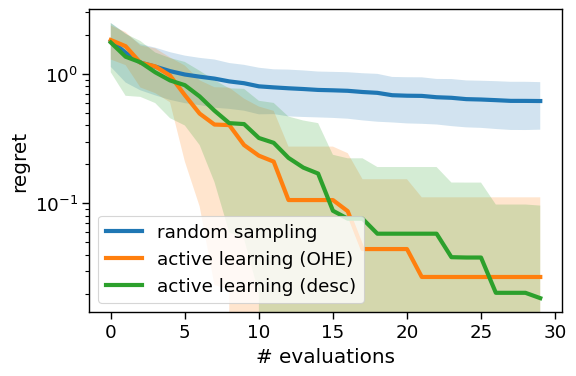

In [15]:
plt.figure(figsize=(6,4))
plt.plot(np.mean(regret_rand,axis=0), lw=3,label='random sampling')
plt.fill_between(
  np.arange(30),
  np.mean(regret_rand,axis=0)-np.std(regret_rand,axis=0),
  np.mean(regret_rand,axis=0)+np.std(regret_rand,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo_ohe,axis=0), lw=3, label='active learning (OHE)')
plt.fill_between(
  np.arange(30),
  np.mean(regret_bo_ohe,axis=0)-np.std(regret_bo_ohe,axis=0),
  np.mean(regret_bo_ohe,axis=0)+np.std(regret_bo_ohe,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo_desc,axis=0), lw=3, label='active learning (desc)')
plt.fill_between(
  np.arange(30),
  np.mean(regret_bo_desc,axis=0)-np.std(regret_bo_desc,axis=0),
  np.mean(regret_bo_desc,axis=0)+np.std(regret_bo_desc,axis=0),
  alpha=0.2
)
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('# evaluations')
plt.legend()
plt.tight_layout()
# plt.savefig('synthetic_general_conditions_gradient.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()

for r in regret_rand:
    ax.plot(r, lw=1, c='b', alpha=0.2)

for r in regret_bo:
    ax.plot(r, lw=2, c='g')

ax.set_yscale('log')
ax.set_ylabel('regret')
ax.set_xlabel('# evaluations')

plt.show()

## Multiobjective problem

In [7]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        #descriptors=[None for i in range(3)],   # OHE
        descriptors=[[float(i),float(i)] for i in range(3)],  # descriptors
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)


In [26]:
BUDGET = 25
NUM_RUNS = 15


#----------
# BayesOpt
#----------

wref = np.array([10000., 10000.])

all_campaigns = []
all_true_measurements = []
all_hvols = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        acquisition_type='general',
        acquisition_optimizer_kind='genetic',
        general_parmeters=[0],
        is_moo=True,
        scalarizer_kind='Hypervolume', 
        value_space=value_space,
        goals=['min', 'min'],   
    )
    planner.set_param_space(param_space)

    true_measurements = []
    hvols = []

    
    iter_=0
    while len(campaign.observations.get_values())<BUDGET:

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements), wref)
            hvols.append(hvol)
            

        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
        
        iter_+=1
    
    all_true_measurements.append(true_measurements)
    all_hvols.append(hvols)
        
    all_campaigns.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5403682393654867, param_2 = 0.29498508236942833, 
param_3 = 0.03181366396183505)]         MEASUREMENT : [4.29722895 4.29722895]
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8882287762929569, param_2 = 0.6573066366678598, 
param_3 = 0.46387437990454694)]  MEASUREMENT : [10.22925679 10.22925679]
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6741430449530487, param_2 = 0.28861435347559283, 
param_3 = 0.5956730404492051)]  MEASUREMENT : [12.06833096 12.06833096]
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6545724878678223, param_2 = 0.8700089783483977, 
param_3 = 0.6785365333325875)]   MEASUREMENT : [2.29332047 2.29332047]
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.957826796723194, param_2 = 0.3109692013302713, 
param_3 = 0.9976814502654318)]    MEASUREMENT : [3.45871843 3.45871843]
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[INFO] Regression surrogate GP trained in 0.16 sec

ValueError: need at least one array to concatenate

In [ ]:

#--------------
# RandomSearch
#--------------

all_campaigns_rand = []
all_true_measurements_rand = []
all_hvols_rand = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = Planner(kind='RandomSearch',goal='minimize',)
    planner.set_param_space(param_space)

    true_measurements_rand = []
    hvols_rand = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_rand.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements_rand), wref)
            hvols_rand.append(hvol)
            


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements_rand.append(true_measurements_rand)
    all_hvols_rand.append(hvols_rand)
        
    all_campaigns_rand.append(campaign)

In [ ]:
# normalize the hypervolumes
all_hvols = np.array(all_hvols)
all_hvols_rand = np.array(all_hvols_rand)
print(all_hvols.shape, all_hvols_rand.shape)

min_ = np.amin(np.concatenate((all_hvols,all_hvols_rand)))
max_ = np.amax(np.concatenate((all_hvols,all_hvols_rand)))

all_hvols = (np.array(all_hvols) - min_) / (max_-min_)
all_hvols_rand = (np.array(all_hvols_rand) - min_) / (max_-min_)

plt.figure(figsize=(6,4))
plt.plot(np.mean(all_hvols,axis=0), lw=3,label='bo')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols,axis=0)-np.std(all_hvols,axis=0),
  np.mean(all_hvols,axis=0)+np.std(all_hvols,axis=0),
  alpha=0.2
)
plt.plot(np.mean(all_hvols_rand,axis=0), lw=3,label='random')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols_rand,axis=0)-np.std(all_hvols_rand,axis=0),
  np.mean(all_hvols_rand,axis=0)+np.std(all_hvols_rand,axis=0),
  alpha=0.2
)
plt.legend()

plt.xlabel('# evaluations')
plt.ylabel('normalized hypervolume')

plt.savefig('moo_general_params.png', dpi=300)

In [ ]:
np.array(all_hvols).shape